# Adaptive PDE discretizations on Cartesian grids
## Volume : Algorithmic tools
## Part : Tensor decomposition techniques
## Chapter : Selling's algorithm, in dimension 2 and 3

$
\newcommand\bZ{\mathbb{Z}}
\newcommand\cE{\mathcal{E}}
\newcommand\cO{\mathcal{O}}
\newcommand\<{\langle} \newcommand\>{\rangle}
$


This notebook presents some tensor decomposition techniques that are at the foundation of our anisotropic PDE discretizations on Cartesian grids. The general objective is to write a given symmetric positive definite matrix $D$ under the form
$$
    D = \sum_{0 \leq i < I} \lambda_i e_i e_i^T. 
$$
From this point, various numerical schemes can be designed, for both first order and second order, and both linear and non-linear PDEs.

The techniques used for constructing the above decomposition are non-trivial, and are related to classical yet subtle tools of discrete geometry. This notebook is meant to illustrate some of their properties.

This notebook is limited to dimensions $d\in \{2,3\}$. Tensor decomposition in dimension $d \in \{4,5\}$ requires another set of techniques (and in practice the call to a c++ library), which are discussed in [II Tensor decomposition, dimensions 4 and 5](TensorVoronoi.ipynb)

**References**

The tensor decomposition presented in this notebook is a central ingredient of the following paper:

Fehrenbach, J., & Mirebeau, J.-M. (2014). Sparse non-negative stencils for anisotropic diffusion. Journal of Mathematical Imaging and Vision, 49(1), 123–147. http://doi.org/http://dx.doi.org/10.1007/s10851-013-0446-3

[**Summary**](Summary.ipynb) of volume Algorithmic tools, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Decomposing a tensor, or a tensor field](#1.-Decomposing-a-tensor,-or-a-tensor-field)
    * [1.1 Case of a $2\times 2$ matrix](#1.1-Case-of-a-$2\times-2$-matrix)
    * [1.2 Case of a $3 \times 3$ matrix.](#1.2-Case-of-a-$3-\times-3$-matrix.)
    * [1.3 Case of (extremely) strong anisotropy](#1.3-Case-of-(extremely)-strong-anisotropy)
    * [1.4 Decomposition a field of symmetric tensors](#1.4-Decomposition-a-field-of-symmetric-tensors)
  * [2. Under the hood : obtuse superbases](#2.-Under-the-hood-:-obtuse-superbases)
    * [2.1 Two dimensions](#2.1-Two-dimensions)
    * [2.2 Three dimensions](#2.2-Three-dimensions)
  * [3. Properties of the decomposition](#3.-Properties-of-the-decomposition)
    * [3.1 Offsets smallness](#3.1-Offsets-smallness)
    * [3.2 Stability](#3.2-Stability)
    * [3.3 Spanning property (no chessboard artifacts)](#3.3-Spanning-property-(no-chessboard-artifacts))
    * [3.4 Piecewise linearity](#3.4-Piecewise-linearity)
  * [4. Smooth two-dimensional decomposition](#4.-Smooth-two-dimensional-decomposition)
    * [4.1 Construction](#4.1-Construction)
    * [4.2 Display of coefficients](#4.2-Display-of-coefficients)
    * [4.3 Linear decomposition](#4.3-Linear-decomposition)
    * [4.4 Automatic differentiation](#4.4-Automatic-differentiation)
  * [5. Convolved decomposition](#5.-Convolved-decomposition)
  * [6. Smooth three-dimensional decomposition](#6.-Smooth-three-dimensional-decomposition)
    * [6.1 Python implementation](#6.1-Python-implementation)
    * [6.2 Comparison with the C++ implementation](#6.2-Comparison-with-the-C++-implementation)



**Acknowledgement.** Some of the experiments presented in these notebooks are part of 
ongoing research with Ludovic Métivier and Da Chen.

Copyright Jean-Marie Mirebeau, Centre Borelli, ENS Paris-Saclay, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('TensorSelling','Algo'))

In [2]:
from agd import LinearParallel as lp
from agd import FiniteDifferences as fd
from agd import Selling
from agd.Plotting import savefig; #savefig.dirName = 'Figures/TensorSelling'
from agd import AutomaticDifferentiation as ad
from agd import Interpolation
from agd.Metrics import Riemann

The library imported as **lp** is a set of routines meant to facilitate the manipulation of *numerous small vectors and matrices* simultaneously. It is based on numpy and implements  only a small number of linear algebra tools.

In [3]:
import numpy as np; xp = np; allclose = np.allclose; π = np.pi
import matplotlib.pyplot as plt
np.set_printoptions(linewidth=2000)

### 0.1 Additional configuration

Uncomment the following line to run the notebook on the GPU. (This only for compatibility testing, since no intensive computation is involved in this specific notebook.)

In [4]:
#xp,plt,allclose=map(ad.cupy_friendly,(xp,plt,allclose))

## 1. Decomposing a tensor, or a tensor field

In order to illustrate our tensor decomposition facilities, we will rely on randomly generated *symmetric positive definite* tensors. They are built as 
$$
    M = A^T A + \varepsilon \mathrm{Id}
$$
where $A$ has normalized random Gaussian entries.

In [5]:
def MakeRandomTensor(dim,shape = tuple(),relax=0.01):
    identity = fd.as_field(np.eye(dim),shape,depth=2)
    A = np.random.standard_normal( (dim,dim) + shape ) 
    M = lp.dot_AA(lp.transpose(A),A) + relax*identity
    return xp.asarray(M) # Convert to GPU array if needed

In [6]:
# For reproducibility, we fix the random seed
np.random.seed(42) 

### 1.1 Case of a $2\times 2$ matrix 


In [7]:
# Generate a 2x2 random psd tensor
D2 = MakeRandomTensor(2)

The **Selling.Decomposition** routine, applies to a symmetric positive definite matrix $D$ of size $d \times d$, with $d\leq 3$. It returns coefficients $\lambda_i \geq 0$ and offsets $e_i \in Z^d$.

A discussion on the inner workings of this decomposition is presented in the next section.

In [8]:
coefs,offsets = Selling.Decomposition(D2)

The matrix can be reconstructed by the formula
$$
    D = \sum_{0 \leq i < I} \lambda_i e_i e_i^T. 
$$

<!---ExoFR
Définissez une fonction qui reconstruit le tenseur D à partir de coefficients $(\lambda_i)_{0\leq i <I}$ et offsets $(e_i)_{0 \leq i < I}$.
--->

<!---ExoCode
def Reconstruct(coefs,offsets):
    """
    Input.
     - coefs :   array of shape   (I,n1,...,nk)
     - offsets : array of shape (d,I,n1,...,nk)
    Output. 
     - D :       array of shape (d,d,n1,...,nk)
    """
    return # TODO.
--->

In [9]:
def Reconstruct(coefs,offsets):
     return (coefs*lp.outer_self(offsets)).sum(2)

In [10]:
assert allclose(D2,Reconstruct(coefs,offsets))

There are $I = d(d+1)/2$ coefficients and offsets (a.k.a $I=3$ if $d=2$, and $I=6$ if $d=3$). Note that this is more than the similar-looking eigen-decomposition of a matrix, which uses only $d$ coefficients and unit vectors. However, Selling's offsets have integer entries, hence are suitable for the construction of finite difference schemes.

In [11]:
print("Selling decomposition of matrix : \n", D2)
print("Coefficients : ", coefs)
print("Offsets : \n", offsets)

Selling decomposition of matrix : 
 [[0.67622539 0.91777115]
 [0.91777115 2.34873696]]
Coefficients :  [0.43467964 0.94787431 0.24154575]
Offsets : 
 [[-1  0  1]
 [-1 -1  2]]


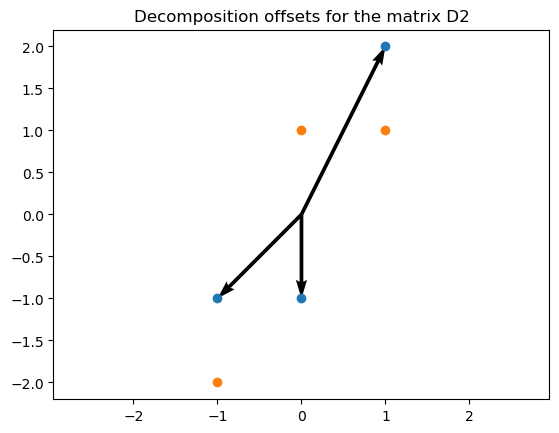

In [12]:
plt.axis('equal'); plt.title("Decomposition offsets for the matrix D2")
plt.quiver(*np.zeros(offsets.shape),*offsets,angles='xy',scale_units='xy',scale=1);
plt.scatter(*offsets); plt.scatter(*(-offsets));

### 1.2 Case of a $3 \times 3$ matrix.

As previously, we generate a 3x3 random psd tensor, decompose it and validate the absence of reconstruction error.

In [13]:
D3 = MakeRandomTensor(3)

In [14]:
coefs,offsets = Selling.Decomposition(D3)

In [15]:
assert allclose(D3,Reconstruct(coefs,offsets))

In [16]:
print("Selling decomposition of matrix : \n", D3)
print("Coefficients : ", coefs)
print("Offsets : \n", offsets)

Selling decomposition of matrix : 
 [[ 0.86853982 -0.08963958 -0.06552819]
 [-0.08963958  0.50213052 -0.73715916]
 [-0.06552819 -0.73715916  2.85683026]]
Coefficients :  [0.15516777 0.08963958 0.62373247 0.23502864 1.49444606 0.1774623 ]
Offsets : 
 [[-1  1 -1  0  0  0]
 [ 0 -1  0  1  0 -1]
 [ 1  1  0 -2  1  1]]


### 1.3 Case of (extremely) strong anisotropy

Selling's tensor decomposition algorithm requires the matrix to be positive definite. It involves a loop, whose number of iterations grows to infinity as the matrix degenerates.

A maximum number of iterations is set by default, to a reasonably large value, so that non-convergence is typically due to an error on the user's side - namely a non-positive matrix. 

In the following cell, we define the following matrix, which is positive definite but strongly anisotropic:
$$
    \begin{pmatrix}
    1 & \varepsilon\\
    \varepsilon & 2 \varepsilon^2
    \end{pmatrix}
$$

In [17]:
# Construct some matrix with extremely large condition number
eps = 1/200.
D2_bad = np.array([[1,eps],[eps,2*eps**2]])

In addition, the anisotropy direction of this matrix is *almost but not exactly* aligned with the coordinate axes, which is a worst case scenario for Selling's algorithm. As a result, Selling's algorithm fails to converge within the prescribed iteration limit.

In [18]:
#Selling's decomposition does not terminate within the iteration limit
try:
    coefs,offsets = Selling.Decomposition(D2_bad)
except ValueError as e:
    print(e.args)

("Selling's algorithm did not terminate in iterMax2=100 iterations",)


The iteration limit of Selling's algorithm may be increased, so as to ensure correct termination.

In [19]:
Selling.iterMax2 *= 2

In [20]:
coefs,offsets = Selling.Decomposition(D2_bad)

However, the resulting offsets are unlikely to be of use for any PDE discretization, since they are way too large. 

Note also that basis reduction techniques more efficient than Selling's algorithm are available for tensors with extremely large condition numbers. (E.g. Lagrange's algorithm.)

In [21]:
print("offsets : \n", offsets)

offsets : 
 [[-99 100  -1]
 [ -1   1   0]]


### 1.4 Decomposition a field of symmetric tensors

Our implementation of Selling's algorithm automatically threads over dimensions deeper than two.

In [22]:
# Generate a 10x10 field of random 2x2 spd tensors
D2_field = MakeRandomTensor(2,(10,10))

In [23]:
coefs, offsets = Selling.Decomposition(D2_field)

The shape of the matrix field is $(d,d, n_1,\cdots,n_k)$, whereas the coefficients are $(I,n_1,\cdots,n_k)$ and the offsets $(d,I,n_1,\cdots,n_k)$ where $I = d (d+1)/2$.

In [24]:
print(f"{D2_field.shape}, {coefs.shape}, {offsets.shape}")

(2, 2, 10, 10), (3, 10, 10), (2, 3, 10, 10)


In [25]:
assert allclose(D2_field,Reconstruct(coefs,offsets))

## 2. Under the hood : obtuse superbases

This section illustrates the main mathematical concept underlying Selling's decomposition, known as *obtuse superbases* of the lattice $Z^d$.

A superbase of $Z^d$ is a special kind of coordinate system $(b_0,\cdots,b_d)$, spanning the lattice of integer points and with some redundancy. More precisely, one requires
$$
\begin{aligned}
    b_0+\cdots+b_d &= 0,\\
    \det(b_1,\cdots,b_d) &= \pm 1.
\end{aligned}
$$
Such a superbase is said $D$-obtuse, where $D$ is a given $d\times d$ symmetric positive definite matrix, if 
$$
    <b_i,D b_j> \leq 0
$$
for all distinct $i,j\in \{0,\cdots,d\}$.

Sellings decomposition of a matrix $D \in S_d^{++}$ is based Selling's formula applied to a $D$-obtuse superbase, which itself is produced by Selling's algorithm.

### 2.1 Two dimensions

The following method applies Selling's algorithm to a given positive definite tensor $D \in S_2^{++}$, producing a suitable superbase of $Z^2$.

<!---ExoFR
Implémenter l'algorithme de Selling, pour construire une superbase $D$-obtuse pour toute matrice symétrique définie positive $D$ donnée de taille $2 \times 2$.

On rappelle que si $(v_0,v_1,v_2)$ est une superbase qui n'est pas obtuse, donc satisfaisant $<v_i,D v_j> > 0$ où $\{i,j,k\}$ est une permutation de $\{0,1,2\}$, alors la règle de mise à jour Selling est 
$$
    (v_0,v_1,v_2) \gets (-v_i,v_j,v_i-v_j).
$$
--->

<!---ExoCode
def ObtuseSuperbase2(D,niter=100):
    """
    Input.
     - D :  array of shape (2,2)
    Output : 
     - sb : array of shape (2,3)
    """
    sb = np.array([[-1,-1],[1,0],[0,1]]) # here of shape (3,2), transposed in the end
    for _ in range(niter):
        for i,j,k in [(0,1,2),(0,2,1),(1,2,0)]:
            # TODO : check if <sb_i, D sb_j> > 0
            # in that case, apply the Selling update rule and break
        else: 
            # All superbase angles are obtuse
            return sb.T
    raise ValueError(f"Selling algorithm failed to converge in {niter} iterations")

# Try your code
sb = ObtuseSuperbase2(D2)
--->

<!---
def ObtuseSuperbase2(D,niter=100):
    sb = np.array([[-1,-1],[1,0],[0,1]])
    for _ in range(niter):
        for i,j,k in [(0,1,2),(0,2,1),(1,2,0)]:
            if lp.dot_VAV(sb[i],D,sb[j]) > 0:
                sb[k] = sb[i]-sb[j]
                sb[i] = -sb[i]
                break
        else: 
            return sb.T
    raise ValueError(f"Selling algorithm failed to converge in {niter} iterations")
--->

In [26]:
sb = Selling.ObtuseSuperbase(D2)

In [27]:
sb

array([[-1., -1.,  2.],
       [ 1., -0., -1.]])

The generated superbase $(b_0,\cdots,b_d)$ is designed to be $D$-obtuse. In other words to obey 
$$
    <b_i,D b_j> \leq 0
$$
for all distinct $i,j\in \{0,\cdots,d\}$.

In [28]:
[lp.dot_VAV(sb[:,i],D2,sb[:,np.mod(i+1,3)]) for i in range(3)]

[-0.2415457537440081, -0.4346796384446704, -0.9478743070679034]

Selling's formula yields the desired decomposition of the given symmetric positive definite matrix $D$
$$
    D = -\sum_{0\leq i<j \leq d} <b_i,D b_j> v_{ij} v_{ij}^T,
$$
where one defines $v_{ij} = \pm b_k^\perp$ whenever $\{i,j,k\} = \{0,1,2\}$. 

Note that, 
* the weight of the decomposition are the negated scalar products, hence are non-negative.
* the offsets of the decomposition are the superbase elements rotated by $\pi/2$, hence have integer coordinates.

<!---ExoFR
Implémentez la formule de reconstruction de Selling, en dimension 2.
--->

<!---ExoCode
def Decomposition2(D):
    coefs = []
    offsets = []
    for i,j,k in [(0,1,2),(0,2,1),(1,2,0)]:
        coefs.append(   # TODO. Append coefficient
        offsets.append( # TODO. Append offset
    return np.array(coefs),np.array(offsets).T
--->

<!---
def Decomposition2(D):
    sb = ObtuseSuperbase2(D)
    coefs = []
    offsets = []
    for i,j,k in [(0,1,2),(0,2,1),(1,2,0)]:
        coefs.append(-lp.dot_VAV(sb[:,i],D,sb[:,j]))
        offsets.append([sb[1,k],-sb[0,k]])
    return np.array(coefs),np.array(offsets).T
--->

In [29]:
coefs,offsets = Selling.Decomposition(D2,sb=sb)

In [30]:
print("Coefficients : ", coefs)
print("Offsets : \n", offsets)

Coefficients :  [0.43467964 0.94787431 0.24154575]
Offsets : 
 [[-1  0  1]
 [-1 -1  2]]


It is possible to produce a tensor decomposition from an arbitrary superbase, but the coefficients are positive only if the superbase is obtuse.

In [31]:
sb = Selling.CanonicalSuperbase(D2) # Only takes the dimension an array type from the argument
coefs,offsets = Selling.Decomposition(D2,sb=sb)
print("Coefficients : ", coefs)
print("Offsets : \n", offsets)

Coefficients :  [-0.91777115  3.26650811  1.59399654]
Offsets : 
 [[ 1  0 -1]
 [-1  1  0]]


In [32]:
assert np.allclose(D2,Reconstruct(coefs,offsets))

### 2.2 Three dimensions

We follow similar steps in dimension $d=3$. Selling's algorithm, applied to the given matrix $D$, yields a specific superbase of $Z^3$.

<!---ExoFR
Implémenter l'algorithme de Selling, pour construire une superbase $D$-obtuse pour toute matrice symétrique définie positive $D$ donnée de taille $3 \times 3$.

On rappelle que si $(v_0,v_1,v_2,v_3)$ est une superbase qui n'est pas obtuse, donc satisfaisant $<v_i,D v_j> > 0$ où $\{i,j,k,l\}$ est une permutation de $\{0,1,2,3\}$, alors la règle de mise à jour Selling est 
$$
    (v_0,v_1,v_2,v_3) \gets (-v_i,v_j,v_k+v_i,v_l+v_i).
$$
--->

<!---ExoCode
def ObtuseSuperbase3(D,niter=100):
    """
    Input.
     - D :  array of shape (3,3)
    Output : 
     - sb : array of shape (3,6)
    """
    # TODO : reprendre et adapter ObtuseSuperbase2
    raise ValueError(f"Selling algorithm failed to converge in {niter} iterations")

# Try your code
sb = ObtuseSuperbase3(D3)
--->

In [33]:
sb = Selling.ObtuseSuperbase(D3)

In [34]:
sb

array([[ 1., -0.,  0., -1.],
       [ 0.,  1.,  1., -2.],
       [ 0.,  1.,  0., -1.]])

The superbase produced by Selling's algorithm is $D$-obtuse, similarly to the two dimensional case.

In [35]:
[lp.dot_VAV(sb[:,i],D3,sb[:,j]) for i in range(4) for j in range(i)]

[-0.1551677694190755,
 -0.08963958172347006,
 -0.2350286383841237,
 -0.6237324732734056,
 -1.4944460568297004,
 -0.1774622969114411]

Selling's formula yields the desired decomposition of the given positive definite matrix $D \in S_3^{++}$:
$$
    D = -\sum_{0\leq i<j \leq d} <b_i,D b_j> v_{ij} v_{ij}^T,
$$
where one defines $v_{ij} = \pm b_k \wedge b_l$ whenever $\{i,j,k,l\} = \{0,1,2,3\}$. 

Note that:
* the weight of the decomposition are the negated scalar products, hence are non-negative.
* the offsets of the decomposition are the cross-products of superbase elements (or their opposites), hence have integer entries.

<!---ExoFR
Implémenter la formule de décomposition de Selling en dimension $d=3$.
--->

<!---ExoCode
def Decomposition3(D):
    """
    Input.
     - D :       array of shape (3,3)
    Output.
     - coefs :   array of shape (6,)
     - offsets : array of shape (3,6)
    """
    coefs = []
    offsets = []
    # TODO : Reprendre et adapter Decomposition2
    return np.array(coefs),np.array(offsets).T
--->

In [36]:
coefs,offsets = Selling.Decomposition(D3)

In [37]:
print("Coefficients : ", coefs)
print("Offsets : \n", offsets)

Coefficients :  [0.15516777 0.08963958 0.62373247 0.23502864 1.49444606 0.1774623 ]
Offsets : 
 [[-1  1 -1  0  0  0]
 [ 0 -1  0  1  0 -1]
 [ 1  1  0 -2  1  1]]


In [38]:
#Comparing with the cross products of the superbase elements.
ad.array(
    [lp.cross(sb[:,i],sb[:,j]) for i in range(4) for j in range(i)]
).astype(int).T

array([[ 0,  0,  1,  0, -1,  1],
       [ 1,  0,  0, -1,  1,  0],
       [-1, -1,  0,  2, -1, -1]])

## 3. Properties of the decomposition

Selling's decomposition of tensors, presented in this notebook, has a qualities that make it particularly suitable for PDE discretizations. More precisely, it is:
* *Local*: The offsets appearing in the decomposition are typically small, and in any case bounded in terms of the anisotropy ratio of the matrix, see below.
* *Stable*: The decomposition is unique, up to trivial transformations (reordering the offsets, and replacing some with their opposites). It is also stable, more precisely the coefficients are locally Lipschitz w.r.t. the decomposed matrix.  
* *Spanning*: The offsets of the decomposition span $Z^d$ by linear relations with integer coordinates. In practice, this means that anisotropic PDE discretizations using this method should not produce chessboard artifacts. 

We denote the *anisotropy ratio* of a symmetric positive definite matrix $D$ by 
$$
    \mu(D) := \sqrt{\|D\| \|D^{-1}\|}.
$$
In other words, this is the square root of the condition number of $D$.

We illustrate these properties in dimension $d=2$, by considering the following family of matrices $D(\theta,\mu) \in S_2^{++}$:
$$
    D(\theta,\mu) := \mu^2 e(\theta) e(\theta)^T + e(\theta)^\perp (e(\theta)^\perp)^T,
$$
whose condition number is equal to $\mu\geq 1$, and whose anisotropy direction is aligned with the vector $e(\theta):=(\cos \theta,\sin \theta)$, $\theta \in R$.

In [39]:
θ = xp.linspace(0,π/2,100)
μ = 10
D2_rotating = (
    μ**2 * lp.outer_self(xp.array([np.cos(θ),np.sin(θ)])) 
    + lp.outer_self(xp.array([-np.sin(θ),np.cos(θ)])) 
)

In [40]:
coefs,offsets = Selling.Decomposition(D2_rotating)

### 3.1 Offsets smallness 

The offsets $(e_i)_{1 \leq i \leq I}$ involved in Selling's decomposition of a tensor $D$ obey
$$
    \|e_i\| \leq C \mu(D),
$$
where $C$ is an absolute constant. 

<!---
np.sqrt(np.sum(offsets**2,axis=0))
--->

In [41]:
offsets_norms = xp.linalg.norm(offsets,axis=0)

In [42]:
print("Sqrt of condition number : ", μ)
print("Largest offset norm : ", np.max(offsets_norms))

Sqrt of condition number :  10
Largest offset norm :  5.0990195135927845


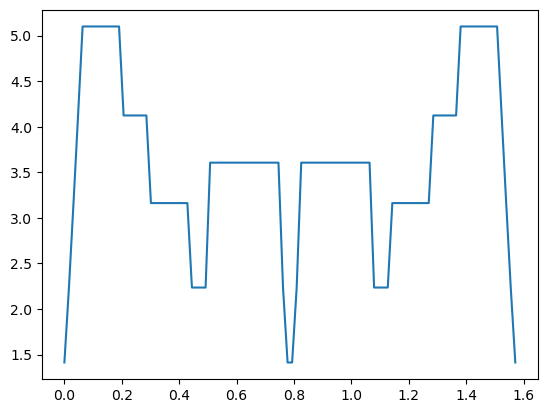

In [43]:
plt.plot(θ,np.max(offsets_norms,axis=0));

### 3.2 Stability

We can rewrite Selling's decomposition in a manner independent of the a specific ordering of the offsets, as follows
$$
    D = \sum_{e \in Z^d} \lambda^e(D) e e^T.
$$
One can then prove that the coefficient $\lambda^e(D)$ of Selling's tensor decomposition, for a given offset $e \in Z^d$, depends continuously on the parameter $D$, as illustrated below. 

In [44]:
decomp = Selling.GatherByOffset(θ,coefs,offsets)

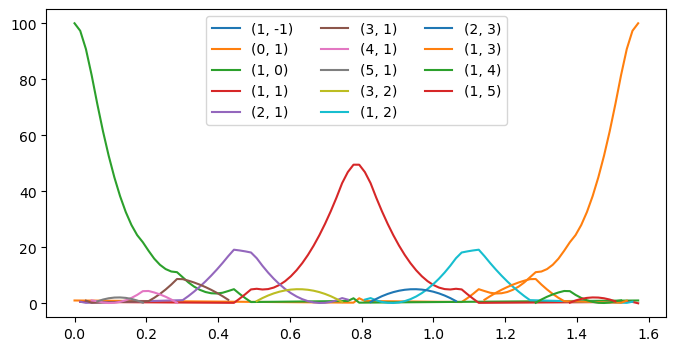

In [45]:
fig = plt.figure(figsize=(8,4))
for offset,(angle,coef) in decomp.items():
    plt.plot(angle,coef)
plt.legend(decomp.keys(),ncol=3);
savefig(fig,"Coefs_Sel2_rot.pdf")

### 3.3 Spanning property (no chessboard artifacts)

The lattice $Z^d$ is spanned, by integer combinations, by the offsets $(e_i)_{1 \leq i \leq I}$ appearing in the decomposition of an arbitrary p.s.d. tensor $D$. In other words, for all $x \in Z^d$, there exists coefficients $k_1,\cdots, k_I \in Z$ such that 
$$
    x = k_1 e_1 + \cdots+ k_d e_d.
$$
In addition, one may select this decomposition so that the weight $\lambda_i$ of $e_i$ is positive whenever $k_i \neq 0$.

This property guarantees that the graph underlying e.g. the discretization of an anisotropic laplacian is locally connected, hence that spurious modes such as chessboard artifacts will not appear. 

From a mathematical standpoint, the spanning property can be deduced from the construction of the decomposition in terms of obtuse superbases. Numerically, we can check it by finding a subset of the offsets whose determinant equals $\pm 1$. 

In [46]:
lp.det(offsets[:,0:2])

array([ 1,  1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1,  1, -1])

In [47]:
coefs,offsets = Selling.Decomposition(D3)

In [48]:
lp.det(offsets[:,0:3])

-1

### 3.4 Piecewise linearity

Selling's coefficients depend in a piecewise linear manner on the decomposed tensor, since by Selling's formula they read $ - <b_i,D b_j>$ where $b_i,b_j$ are elements of a $D$-obtuse superbase $(b_0,\cdots,b_d)$. This property is exploited, in some (somewhat sophisticated) numerical schemes, e.g. for the [Pucci](../Notebooks_NonDiv/NonlinearMonotoneSecond2D.ipynb) and [Monge Ampere](../Notebooks_NonDiv/MongeAmpere.ipynb) PDEs.

In [49]:
def Interpolate(a,b,T=np.linspace(0,1,100)):
    return T, np.moveaxis(ad.array([(1-t)*a + t*b for t in T]),0,-1)

In [50]:
np.random.seed(42)
t,D2t = Interpolate(MakeRandomTensor(2),MakeRandomTensor(2))
decomp = Selling.GatherByOffset(t,*Selling.Decomposition(D2t))

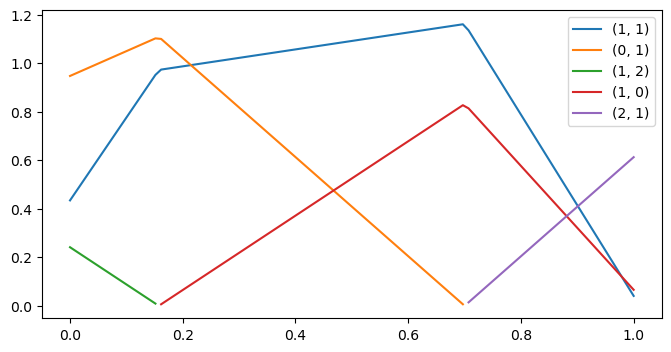

In [51]:
fig = plt.figure(figsize=(8,4))
for offset,(time,coef) in decomp.items(): plt.plot(time,coef)
plt.legend(decomp.keys());

In [52]:
np.random.seed(1)
t,D3t = Interpolate(MakeRandomTensor(3),MakeRandomTensor(3))
decomp = Selling.GatherByOffset(t,*Selling.Decomposition(D3t))

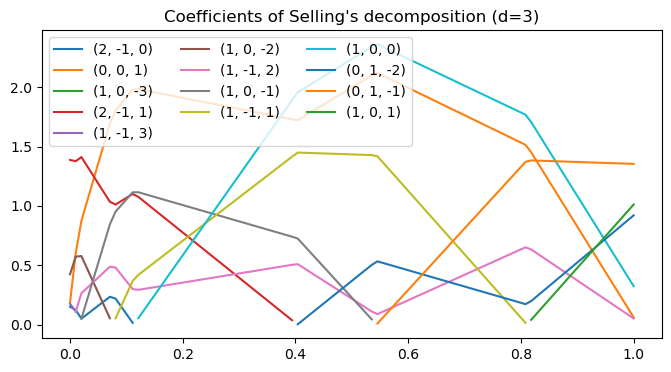

In [53]:
fig = plt.figure(figsize=(8,4)); plt.title("Coefficients of Selling's decomposition (d=3)")
for offset,(time,coef) in decomp.items(): plt.plot(time,coef)
plt.legend(decomp.keys(),ncol=3)
savefig(fig,"Coefs_Sel3.pdf")

## 4. Smooth two-dimensional decomposition

The coefficients of Selling's decomposition are piecewise linear, hence have Lipschitz regularity, but not better. In some applications it is preferable, at least from the theoretical standpoint, to define a decomposition whose coefficients have a *Lipschitz gradient*, or whose *square root is Lipschitz*. We describe such a construction in the following.

### 4.1 Construction

Two auxiliary functions are needed for our smooth variant of Selling's decomposition. The first one is a regularized substitude for the absolute value, smoothed within the interval $[-1,1]$.

In [54]:
def sabs(x,order):
    """
    Regularized absolute value. Guarantee : 0 <= result-|x| <= 1/2.
    - order (0, 1, 2 or 3) : order of the last continuous derivative. 
    """
    x = np.abs(x) # Actually useless for this specific application
    if order==0: return x # Continuous value
    elif order==1: return np.where(x<=1, 0.5*(1+x**2), x) # Continuous derivative
    elif order==2: return np.where(x<=1, (3+6*x**2-x**4)/8,x) # Continuous second order derivative
    elif order==3: return np.where(x<=1, (5+15*x**2-5*x**4+x**6)/16,x) # Continuous second order derivative
    else: raise ValueError(f"Unsupported {order=} in sabs")

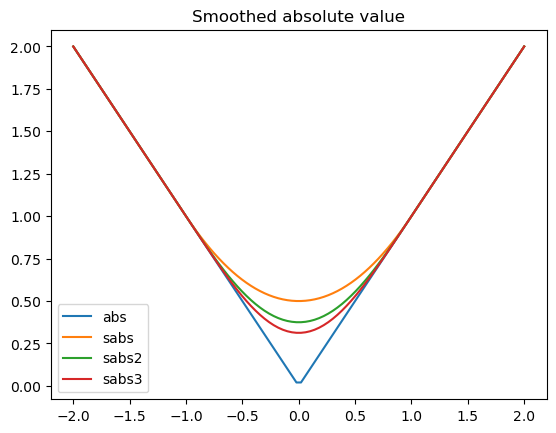

In [55]:
x=np.linspace(-2,2,100)
plt.plot(x,sabs(x,order=0),label="abs")
plt.plot(x,sabs(x,order=1),label="sabs")
plt.plot(x,sabs(x,order=2),label="sabs2")
plt.plot(x,sabs(x,order=3),label="sabs3")
plt.title("Smoothed absolute value")
plt.legend();

The second auxiliary function is a regularized substitute for the median of three positive reals $\rho_0,\rho_1,\rho_2$. In addition, the result is also defined in terms of two quantities denoted $s$ and $q$, that are chosen for their invariance under Selling's superbase operations.

In [56]:
def smed(ρ0,ρ1,ρ2):
    """Regularized median (a.k.a. ρ1) assuming ρ0<=ρ1<=ρ2.
    Guarantee : ρ1/(2*sqrt(2)) <= result < ρ1"""
    s,q = ρ0*ρ1+ρ1*ρ2+ρ2*ρ0, (ρ2-ρ1)**2 # Invariant quantities under Selling superbase flip 
    return 0.5*s/np.sqrt(q+2*s) 

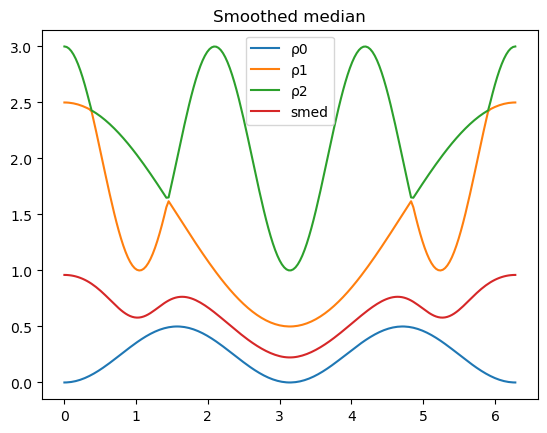

In [57]:
t = np.linspace(0,2*π,200)
ρ0,ρ1,ρ2 = np.sort([1.5+np.cos(t),0.5*np.sin(t)**2,np.cos(3*t)+2],axis=0)
plt.plot(t,ρ0, t,ρ1, t,ρ2, t,smed(ρ0,ρ1,ρ2))
plt.title("Smoothed median")
plt.legend(['ρ0','ρ1','ρ2', 'smed']);

Consider a positive definite matrix $D$, and a $D$-obtuse superbase $(v_0,v_1,v_2)$.
Define the Selling weights $\rho_i = -<e_{i-1},D e_{i+1}>$, with periodic indices, and offsets $e_i = v_i^\perp$. Assume that $\rho_0\leq \rho_1\leq \rho_2$, up to permuting the basis elements.

Our regularized Selling decomposition takes the following form, with $m = \mathrm{smed}(\rho_0,\rho_1,\rho_2)$.
$$
    D = \sum_{0 \leq i \leq 2} \rho_i e_i e_i^\top + \frac 1 2 (m\, \mathrm{sabs}(\rho_0/m)-\rho_0)(e_0 e_0^\top - 2 e_1 e_1^\top - 2 e_2 e_2^\top + (e_1-e_2)(e_1-e_2)^\top).
$$
Note that the first term $\sum_{0 \leq i \leq 2} \rho_i e_i e_i^\top$ is Selling's standard decomposition of $D$. The second term amounts to zero, since $e_0 e_0^\top - 2 e_1 e_1^\top - 2 e_2 e_2^\top + (e_1-e_2)(e_1-e_2)^\top = 0$, but it introduces the additional offset $e_1-e_2$ and modifies the weights in a smooth manner.

In [58]:
def smooth_decomp(D,order=3):
    """Smooth variant of Selling's two dimensional decomposition"""
    v = np.moveaxis(Selling.ObtuseSuperbase(D),1,0)
    ρ = np.array([-lp.dot_VAV(v[1],D,v[2]),-lp.dot_VAV(v[0],D,v[2]),-lp.dot_VAV(v[0],D,v[1])])
    ord = np.argsort(ρ,axis=0) 
    v = np.take_along_axis(v,ord[:,None],axis=0); ρ=np.take_along_axis(ρ,ord,axis=0)

    m = smed(*ρ)
    w = np.maximum(0,m*sabs(ρ[0]/m,order)-ρ[0]) # Positive up to roundoff error (max for safety)
    
    return (ad.array([ρ[0]+w/2, ρ[1]-w, ρ[2]-w, w/2]),
         lp.perp(np.moveaxis(ad.array([v[0],v[1],v[2],v[1]-v[2]]),0,1)).astype(int) )

### 4.2 Display of coefficients

Recall that Selling's decomposition has piecewise linear coefficients.

In [59]:
np.random.seed(42)
t,D2t = Interpolate(MakeRandomTensor(2),MakeRandomTensor(2))
if xp is not np: D2t = D2t.get() # Bug with cupy 9.0 and np.zeros_like below

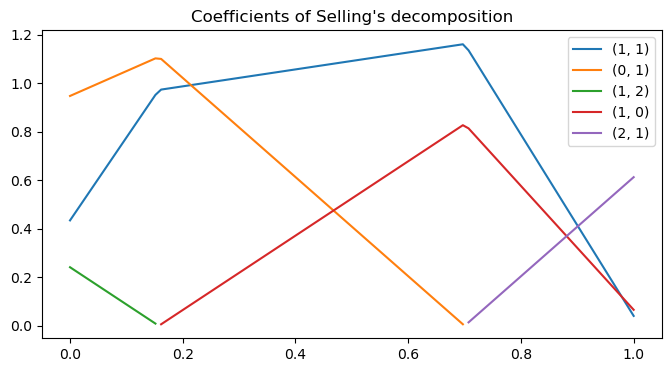

In [60]:
fig = plt.figure(figsize=(8,4)); plt.title("Coefficients of Selling's decomposition")
decomp = Selling.GatherByOffset(t,*Selling.Decomposition(D2t))
for offset,(time,coef) in decomp.items(): plt.plot(time,coef)
plt.legend(decomp.keys()); savefig(fig,"Coefs_Sel2.pdf")

In this section, we constructed a matrix decomposition whose coefficients have a bounded second order derivative.

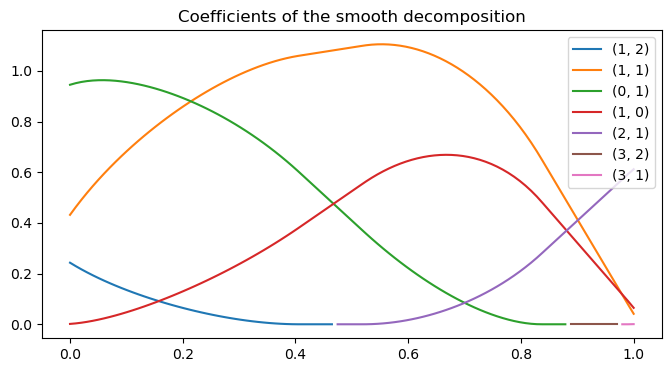

In [61]:
fig = plt.figure(figsize=(8,4)); plt.title("Coefficients of the smooth decomposition")
decomp = Selling.GatherByOffset(t,*smooth_decomp(D2t,order=1))
for offset,(time,coef) in decomp.items(): plt.plot(time,coef)
plt.legend(decomp.keys()); savefig(fig,"Coefs_Smooth.pdf")

In particular, their square root is Lipschitz, a property used in some convergence analyses.

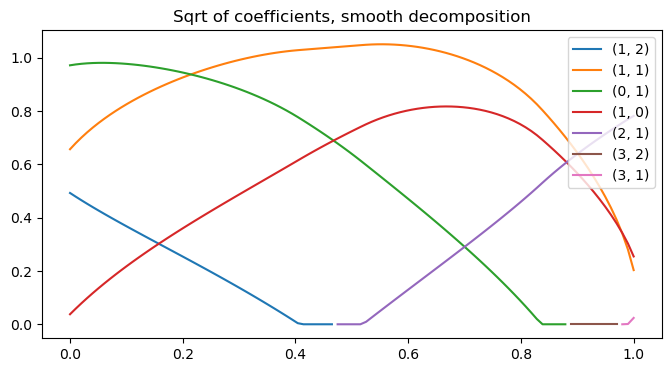

In [62]:
fig = plt.figure(figsize=(8,4)); plt.title("Sqrt of coefficients, smooth decomposition")
for offset,(time,coef) in decomp.items(): plt.plot(time,np.sqrt(coef))
plt.legend(decomp.keys(),loc="upper right"); savefig(fig,"SqCoefs_Smooth.pdf")

Choosing `order=3` in the absolute value regularization, we obtain coefficients wanishing like $\cO(x^4)$, hence their square root vanishes like $\cO(x^2)$, differentiably.

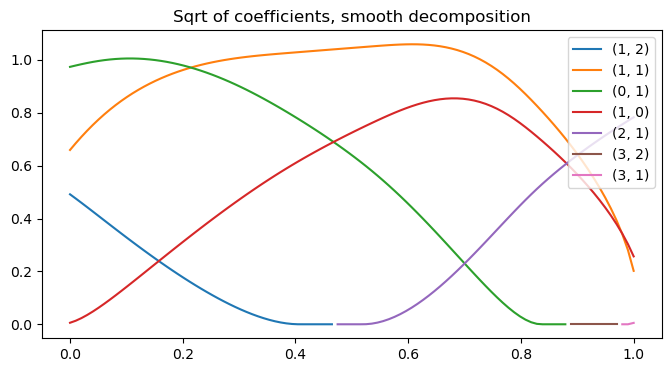

In [63]:
decomp = Selling.GatherByOffset(t,*smooth_decomp(D2t,order=3))
fig = plt.figure(figsize=(8,4)); plt.title("Sqrt of coefficients, smooth decomposition")
for offset,(time,coef) in decomp.items(): plt.plot(time,np.sqrt(coef))
plt.legend(decomp.keys(),loc="upper right"); savefig(fig,"SqCoefs_Smooth3.pdf")

### 4.3 Linear decomposition

Selling's decomposition is piecewise linear, and is non-differentiable close to the identity matrix.
In contrast, it can be useful in some applications to have a positive matrix decomposition that is smooth (as the previous one) or even better linear in a neighborhood of the identity matrix. We provide the following routine, which provides such a linear and non-negative decomposition for all positive definite matrices $D$ such that 
$$
    \kappa \lambda_{\max}(D) \leq \lambda_{min}(D), \quad \kappa:= \frac {d-1}{d+1},
$$
using a fixed stencil of $d^2$ points.
It appears that no decomposition with a fixed stencil and linear weights applies to a larger neighborhood of the identity matrix, defined by a smaller constant $\kappa$ (unless there is an error in my calculations).

In [64]:
def linear_decomp_offsets(d):
    """The stencil for this linear decomposition is fixed and has $d^2$ elements"""
    e = xp.eye(d).astype(int)
    return np.concatenate(
        (e,xp.array([e[i]+s*e[j] for i in range(d) for j in range(i) for s in (-1,1)])),axis=0).T

def linear_decomp_coefs(D):
    """These weights depend linearly on the matrix $D$"""
    d=len(D)
    α=(d+1)/(2*d); β=-1/(2*d); γ=1/(4*d); δ=1/4; # ε=(d-1)/(d+1)
    t = sum(D[i,i] for i in range(d))
    return np.concatenate((ad.array([(α-β)*D[i,i]+β*t for i in range(d)]),
        ad.array([γ*(D[i,i]+D[j,j])+s*δ*(D[i,j]+D[j,i]) for i in range(d) 
        for j in range(i) for s in (-1,1)]) ),axis=0)

def linear_decomp(D): return linear_decomp_coefs(D),linear_decomp_offsets(len(D))

In [65]:
print("Two dimensional stencil:\n",linear_decomp_offsets(2))
print("Three dimensional stencil:\n",linear_decomp_offsets(3))

Two dimensional stencil:
 [[ 1  0 -1  1]
 [ 0  1  1  1]]
Three dimensional stencil:
 [[ 1  0  0 -1  1 -1  1  0  0]
 [ 0  1  0  1  1  0  0 -1  1]
 [ 0  0  1  0  0  1  1  1  1]]


We numerically check the announced properties of this linear decomposition, in dimensions $2$ and $3$, on a hundred matrices.

In [66]:
d=2; D = MakeRandomTensor(d,(100,),relax=0.5) 
coefs,offsets = linear_decomp_coefs(D),linear_decomp_offsets(d)

# Check reconstruction
assert allclose(Reconstruct(coefs,offsets[...,None]),D)

# Check positivity for sufficiently well conditioned matrices
poscoef = np.min(coefs,axis=0)>=0
λmin,λmax = np.linalg.eigvalsh(np.moveaxis(D,-1,0)).T
illcond = λmin < (d-1)/(d+1)*λmax
assert np.all(poscoef | illcond)

In [67]:
d=3; D = MakeRandomTensor(d,(100,),relax=0.5)
coefs,offsets = linear_decomp_coefs(D),linear_decomp_offsets(d)

# Check reconstruction
assert np.allclose(Reconstruct(coefs,offsets[...,None]),D)

# Check positivity for sufficiently well conditioned matrices
poscoef = np.min(coefs,axis=0)>=0
λmin,_,λmax = np.linalg.eigvalsh(np.moveaxis(D,-1,0)).T
illcond = λmin < (d-1)/(d+1)*λmax
assert np.all(poscoef | illcond)

### 4.4 Automatic differentiation

**Selling's decomposition** This decomposition is piecewise linear. The code is compatible with automatic differentiation, but the AD part is unstable at points of non-differentiability, which include the identity matrix.

In [68]:
np.random.seed(42)
D0 = ad.Dense.identity(constant=xp.eye(2)) # identity matrix + symbolic first order perturbation
D0 = (D0+D0.T)/2 # Symmetrize the first order part
D1 = D0 + 1e-4*xp.asarray(np.random.rand(2,2)-0.5) # A perturbation

The matrices $D_0$ and $D_1$ are close, and so are their Selling decompositions.
(Note that the stencil for $D_0$, the identity matrix, is not uniquely determined, but the Selling weight associated to the modified stencil elements is zero anyway.)
However, the first order AD parts are different.

<!---
λ0,e0 = Selling.Decomposition(D0)
λ1,e1 = Selling.Decomposition(D1)
print(λ0-λ1)
--->

In [69]:
λ0,e0 = Selling.Decomposition(D0)
λ1,e1 = Selling.Decomposition(D1)
# In other cases, λ1 may need to be permuted, to account for arbitrary ordering of e0,e1
λdiff = λ0-λ1
assert np.max(np.abs(λdiff.value)) < 1e-4 # The coefficients values are close
np.max(np.abs(λdiff.coef)) # The coefficient derivatives are different

1.0

**Smoothed variant of Selling's decomposition.** The previous instability phenomenon is avoided with the smooth variant of the decomposition.

Note that the *ordering* of the stencil elements, is not uniquely determined. But this can be dealt with easily by putting them into some canonical ordering.

In [70]:
λ0,e0 = smooth_decomp(D0)
λ1,e1 = smooth_decomp(D1)
# λ1 is reversed here to account for reversed ordering of the offsets e0 and e1 
# (An arbitrary permutation is possible in general)
λdiff = λ0-λ1[::-1] 
assert np.max(np.abs(λdiff.value))<1e-4 # The coefficients are close
assert np.max(np.abs(λdiff.coef))<2e-4 # The coefficient derivatives are close

**Linear variant.**
The linear decomposition presented above only applies to positive definite matrices whose condition number is sufficiently small. Since it linear, however, not only the coefficients are close, but their derivatives are identical. The offsets are also, of course, identical.

In [71]:
λ0 = linear_decomp_coefs(D0)
λ1 = linear_decomp_coefs(D1)
λdiff = λ0-λ1 # Always the same ordering here
assert np.max(np.abs(λdiff.value))<1e-4 # The coefficients are close
assert np.max(np.abs(λdiff.coef))==0 # Their derivatives are identical

## 5. Convolved decomposition

Another approach to obtain smooth Selling-like coefficients and decomposition is to convolve them. However, this raises the issue of the consistency of the matrix decomposition. 

If the matrix field is initially given as a convolution,
$$
    D = D_0 \star G_\sigma,
$$
where $G_\sigma$ is e.g. a Gaussian kernel, one simply needs to decompose $D_0$ 
$$
    D_0(x) = \sum_{e \in \bZ^d} \lambda_0^e (x) e e^\top
$$
and convolve the obtained coefficients 
$$
    D(x) = \sum_{e \in \bZ^d} \lambda^e(x) e e^\top, \text{ where } \lambda^e = \lambda^e_0 \star G_\sigma.
$$

**Possible applications.**
In some cases, the matrix field $D$ may be directly given in a convolution form. For instance, in seismic tomography, the model coefficients are obtained from gradient backpropagation, which undergoes Gaussian smoothing. 
In general, however, the matrix field $D(x)$ has no reason to be of this form. If it is sufficiently smooth, however, then one may de-convolve $D$ to obtain $D_0$. 
We choose deconvolve using the routines developed for spline coefficients, which have a small stencil of $k$ pixels for order $k$ splines.

Deconvolution is easily computed using the Fourier transform. More precisely, consider the optimization problem
$$
    \min_u \|G \star u - v\|^2 + \epsilon^2 \|u\|^2,
$$
where $G$ is some convolution kernel, and $\epsilon>0$ is a relaxation parameter.
Assuming periodic boundary conditions, the solution is obtained explicitly as 
$$
    \hat u := \frac {\overline {\hat G} v}{\epsilon^2 + |\hat G|^2}.
$$


**Notes of caution.**
- (Unstability) De-convolution is in unstable, in the limit as $\epsilon\to 0$. One of the consequences of this unstability is that the deconvolved tensors may not be positive definite.
- (Number of coefficients and complexity.) The number of positive coefficients $\#\{e \mid \lambda^e(x)>0\}$ after convolution exceeds the original number $\#\{e \mid \lambda^e_0(x)>0\}$, possibly substantially. Very small coefficients are eventually pruned, but the convolution computation may hold large intermediate results. In addition, one cannot bound a priori the number of positive decomposition coefficients. 

**Alternatives** If the dimension is $d=2$, or if the condition number is sufficiently small, the one can use then the previously introduced smooth and linear decompositions. In dimension $d=3$, we also present below a smooth decomposition, albeit more experimental and costly.

<!---
def conv_circulant(circ,val):
    from numpy.fft import fft,ifft
    """Product of a circulant matrix with an array of values, computed using the FFT."""
    return np.moveaxis(ifft(fft(np.moveaxis(val,0,-1)) * fft(circ)).real,-1,0)

def conv_decomp(D,order=5,periodic=True,rtol=1e-10):
    """Deconvolve the matrix field D, apply Selling's decomposition, then convolve the coefficients.
    - D : positive definite matrix field, of shape (d,d,n1,...,nk). Convolution is applied to axes n1,...,nk.
    - order (either 3, 5 or 7): spline interpolation order
    - periodic : choose between periodic and reflected boundary conditions
    - rtol : relative tolerance for eliminating small coefficients.
    """
    D = Interpolation.spline_coefs(D,depth=2,order=order,periodic=periodic) # Deconvolution
    tol = rtol * lp.trace(D) # Compute absolute tolerance
    λ,e = Selling.Decomposition(D) # Selling decomposition
    vdim = len(e)
    shape = λ[0].shape
    pos = np.argmax(e!=0,axis=0) # position of the first non-zero coefficient
    e *= np.sign(np.take_along_axis(e,pos[None],0)) # Normalized offset, starts > 0
    emax = np.max(np.abs(e))
    r = 2*emax+1 # Base exponent for conversion to integer
    ie = sum(e[i] * r**(vdim-i-1) for i in range(vdim)) # Convert offsets to integers
    Λ = ad.Sparse.spAD(np.zeros_like(λ[0]),np.moveaxis(λ,0,-1),np.moveaxis(ie,0,-1))
    Λ = Λ.tangent_operator().todense() # Possible improvement : optimization opportunities here
    Λ = np.moveaxis(np.asarray(Λ).reshape((*shape,-1)),-1,0)
    Λ = Interpolation.spline_coefs(Λ,depth=1,solver=conv_circulant,order=order,periodic=periodic)
    Λ = np.roll(Λ,order-1,axis=tuple(range(1,Λ.ndim)))
    Λ[np.abs(Λ)<=tol]=0 # Remove almost zero coefficients
    index = fd.as_field(np.arange(len(Λ)),shape,depth=1)
    x = ad.Sparse.spAD(np.zeros_like(λ[0]),np.moveaxis(Λ,0,-1),np.moveaxis(index,0,-1))
    x.simplify_ad() # Remove null coefficients.
    λ = np.moveaxis(x.coef,-1,0) # The new coefficients
    ie = np.moveaxis(x.index,-1,0) # The new offsets, for now as integers
    e = []
    for i in range(vdim):
        mod = ie%r
        pos = mod>emax
        ie = (ie//r)+pos
        e.append(np.where(pos,mod-r,mod))
    return λ,np.array(e[::-1])
--->

In [72]:
def deconv(arr,σ=5.,ϵ=0.05,periodic=True,depth=0,real=True):
    """
    Input : 
    - σ : standard deviation of Gaussian kernel in pixels. Alternatively, provide an exact kernel. (Same for all axes.)
    - ϵ : stability parameter for the deconvolution
    - periodic : choose between periodic and reflected boundary conditions
    - depth : initial dimensions, not touched by the convolution
    - real : extract the real part after convolutions, deconvolutions

    Returns : 
    - deconvolved array
    - function to convolve back
    """
    from numpy.fft import fft,ifft
    fkernels = []
    def reflect(arr,axis): return np.concatenate((arr,arr[(slice(None),)*axis+(slice(None,None,-1),)]),axis)
    def half(arr,axis): return arr[(slice(None),)*axis+(slice(0,arr.shape[axis]//2),)]
    for i,s in enumerate(arr.shape[depth:]):
        s2 = s if periodic else 2*s # Size of kernel
        if np.ndim(σ)==0: # Use Gaussian convolution kernel
            x = np.arange(s2)
            x[x>=x.size/2]-=x.size # Periodic boundary conditions
            kernel = np.exp(-x**2/(2*σ**2)) / (np.sqrt(2*π)*σ)
        elif np.ndim(σ)==1: # Use provided kernel
            kernel = np.roll(np.pad(σ,(0,s2-len(σ))),-(len(σ)//2))
        fkernel = fft(kernel)
        fkernels.append(fkernel)
        ikernel = np.conj(fkernel)/(ϵ**2+np.abs(fkernel)**2) # Deconvolution kernel
        if not periodic: arr = reflect(arr,depth+i)
        arr = ifft(fft(arr,axis=depth+i)*np.expand_dims(ikernel,tuple(range(depth+1+i-arr.ndim,0))),axis=depth+i)
        if not periodic: arr = half(arr,depth+i)
        if real: arr = arr.real

    def conv(arr,depth=depth):
        for i,fkernel in enumerate(fkernels):
            if not periodic: arr = reflect(arr,depth+i)
            arr = ifft(fft(arr,axis=depth+i)*np.expand_dims(fkernel,tuple(range(depth+1+i-arr.ndim,0))),axis=depth+i)
            if not periodic: arr = half(arr,depth+i)
            if real: arr = arr.real
        return arr
    
    return arr,conv

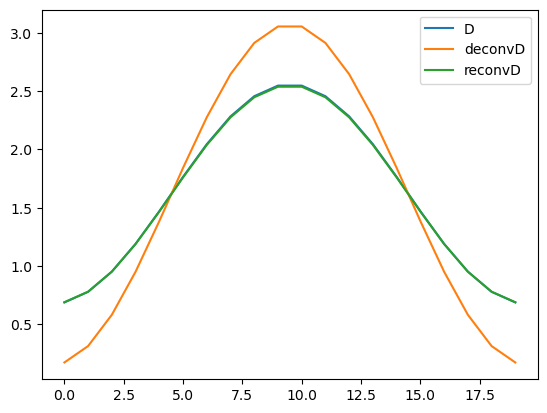

In [73]:
np.random.seed(42)
D0 = MakeRandomTensor(2)
D1 = MakeRandomTensor(2)
t,dt = np.linspace(0,π,20,endpoint=False,retstep=True) # True periodicity with endpoint=False only
t+=dt/2
D = D0[:,:,None]*np.cos(t)**2 + D1[:,:,None]*np.sin(t)**2
deconvD,reconv = deconv(D,σ=3.,depth=2,ϵ=0.05,periodic=False)
reconvD = reconv(2*deconvD)/2
plt.plot(D[0,0],label='D')
plt.plot(deconvD[0,0],label='deconvD')
plt.plot(reconvD[0,0],label='reconvD') 
plt.legend();

In [74]:
def conv_decomp(deconvD,conv,rtol=1e-6):
    """Apply Selling's decomposition, then convolve the coefficients, and finally prune the small ones.
    - deconvD : deconvolved positive definite matrix field. 
    - conv : convolution operator
    - rtol : relative tolerance for eliminating small coefficients.
    """
    tol = rtol * lp.trace(deconvD) # Compute absolute tolerance
    λ,e = Selling.Decomposition(deconvD) # Selling decomposition
    vdim = len(e)
    shape = λ[0].shape
    pos = np.argmax(e!=0,axis=0) # position of the first non-zero coefficient
    e *= np.sign(np.take_along_axis(e,pos[None],0)) # Normalized offset, starts > 0
    emax = np.max(np.abs(e))
    r = 2*emax+1 # Base exponent for conversion to integer
    ie = sum(e[i] * r**(vdim-i-1) for i in range(vdim)) # Convert offsets to integers
    Λ = ad.Sparse.spAD(np.zeros_like(λ[0]),np.moveaxis(λ,0,-1),np.moveaxis(ie,0,-1))
    Λ = Λ.tangent_operator().todense() # Possible improvement : optimization opportunities here
    Λ = np.moveaxis(np.asarray(Λ).reshape((*shape,-1)),-1,0)
    Λ = conv(Λ,depth=1)
    Λ[np.abs(Λ)<=tol]=0 # Remove almost zero coefficients
    index = fd.as_field(np.arange(len(Λ)),shape,depth=1)
    x = ad.Sparse.spAD(np.zeros_like(λ[0]),np.moveaxis(Λ,0,-1),np.moveaxis(index,0,-1))
    x.simplify_ad() # Remove null coefficients.
    λ = np.moveaxis(x.coef,-1,0) # The new coefficients
    ie = np.moveaxis(x.index,-1,0) # The new offsets, for now as integers
    e = []
    for i in range(vdim): # Expand the offsets, as vectors
        mod = ie%r
        pos = mod>emax
        ie = (ie//r)+pos
        e.append(np.where(pos,mod-r,mod))
    return λ,np.array(e[::-1])

In order to check the correctness of the code, we remove the relaxation parameter $\epsilon=0$, and check for machine precision equality.

In [75]:
D0,D1,D2 = (np.eye(2),[[1,-0.1],[-0.1,1]],[[1,0.1],[0.1,1]])
D = np.stack((D0,D1,D2,D0,D2,D0,D1),axis=-1)
for order in (3,5,7):
    σ = Interpolation.spline_base(0,3)[1:] # Using a convolution kernel corresponding to spline interpolation
    deconvD,reconv = deconv(D,σ,ϵ=0,depth=2) # No relaxation (ϵ=0)
    assert np.allclose(reconv(deconvD),D) # Reconvolution of D is exact
    λ,e = conv_decomp(deconvD,reconv,rtol=1e-10)
    rec = np.sum(λ*lp.outer_self(e),axis=2)
    assert np.allclose(rec,D) # Reconstruction of D from convolved coefficients is exact

In [76]:
np.random.seed(42)
D0 = MakeRandomTensor(2)
D1 = MakeRandomTensor(2)
t = np.linspace(0,π,100,endpoint=False)
D2t = D0[:,:,None]*np.cos(t)**2 + D1[:,:,None]*np.sin(t)**2

Tuning the convolution kernel width $\sigma$ (measured in pixels) requires some attention : 
- if $\sigma$ is too small, then the obtained coefficients are not very smooth.
- if $\sigma$ is too large, then the deconvolved matrices may be highly anisotropic or non-positive. As a result, Selling's decomposition may involve large offsets or fail.

In the example below, $\sigma = 3$ is the good choice.

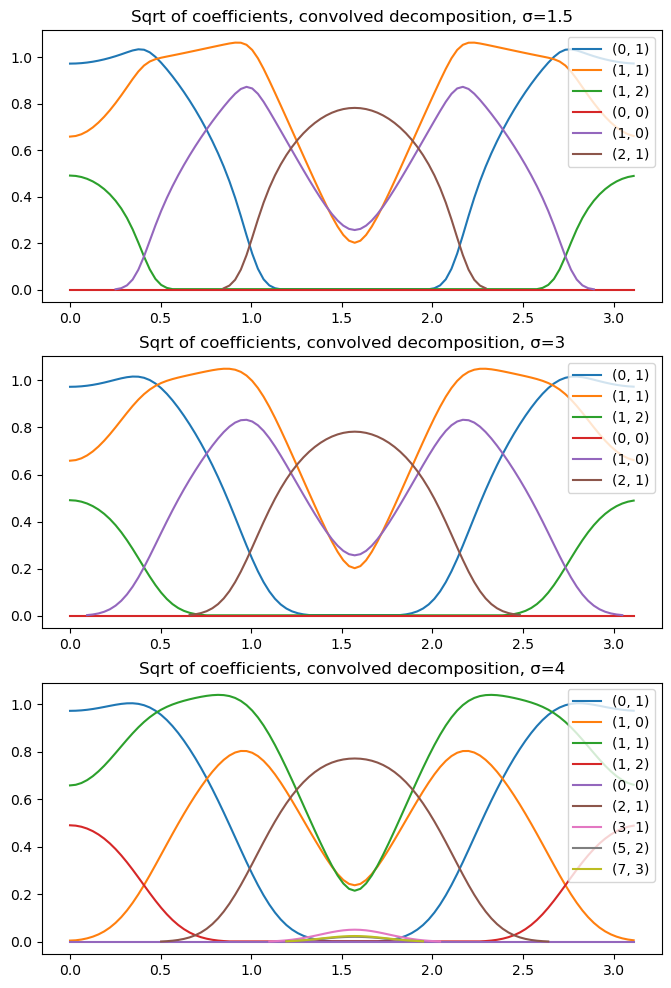

In [77]:
plt.figure(figsize=[8,12])
for i,σ in enumerate((1.5,3,4)):
    λ,e = conv_decomp(*deconv(D2t,σ,depth=2))
    rec = np.sum(λ*lp.outer_self(e),axis=2)

    decomp = Selling.GatherByOffset(t,λ,e)
    plt.subplot(3,1,1+i)
    plt.title(f"Sqrt of coefficients, convolved decomposition, {σ=}")
    for offset,(time,coef) in decomp.items(): plt.plot(time,np.sqrt(coef))
    plt.legend(decomp.keys(),loc="upper right"); savefig(fig,f"SqCoefs_Conv{order}.pdf")

## 6. Smooth three-dimensional decomposition

As a proof of concept, we present a smooth variant of Selling's three dimensional decomposition. 

**Superbases and Selling's transformation.** In order to describe our matrix decomposition, we recall that a superbase of $\bZ^3$ is a tuple $(b_0,b_1,b_2,b_3)\in (\bZ^3)^4$ such that 
\begin{align*}
    b_0+b_1+b_2+b_3 &=0, & |\det(b_1,b_2,b_3)| &=1.
\end{align*}
In our application, superbases are considered up to a re-ordering of their elements, and to a global change of sign $(-b_0,-b_1,-b_2,-b_3)$. Given a matrix $D \in S_3^{++}$, the energy of a superbase reads
$$
    \cE_D(b_0,b_1,b_2,b_3) = \frac 1 2 \sum_{0 \leq i \leq 3} \|b_i\|_D^2.
$$ 
Selling's transformation of a superbase takes the form $(-b_i,b_j,b_i+b_k,b_i+b_l)$
where $(i,j,k,l)$ is any permutation of $(0,1,2,3)$. It satisfies
$$
    \cE_D(-b_i,b_j,b_i+b_k,b_i+b_l) = \cE_D(b_0,b_1,b_2,b_3) - \<b_i,D b_j\>. 
$$

Selling's algorithm starts from an arbitrary superbase, and iteratively applies Selling's transformations whenever a pair of indices $(i,j)$ satisfies $\<b_i,D b_j\> > 0$. It can be shown that this procedure terminates, thus produces an $D$-obtuse superbase (i.e. $\<b_i,D b_j\> \leq 0$, for any pair of indices), which globally minimizes the energy $\cE_D$ among all superbases.

Eventually, Selling's decomposition reads denoting $v_{ij} := b_i \times b_j$
$$
    D = \sum_{0\leq i<j\leq 3} (-\<b_i,D b_j\>) v_{ij} \otimes v_{ij}.
$$
It can be shown that this decomposition, whose coefficients can be denoted $\lambda : \bZ^3 \to [0,\infty[$, is a global minimizer to the linear program defined by maximizing 
\begin{align*}
    & \sum_{e \in \bZ^3\setminus\{0\}} \lambda(e) & \text{s.t.}\quad D &= \sum_{e \in \bZ^3} \lambda(e) e e^\top.
\end{align*}


**Variant of the decomposition.**
The idea is to solve a modified optimization problem, featuring penalty terms depending on the matrix $D$ and providing some control over the  decomposition coefficients $\lambda$ : a logarithmic barrier enforces their positivity, and a quadratic penalization ensures their smallness. The penalty terms must depend smoothly on $D$, and be carefully tuned to ensure that the solution exists and depends smoothly on $D$.  

I slightly more detail, the steps of the modified decomposition are as follows : 
1. Attribute weights $\rho_D(B)$ to all superbases of $\bZ^3$ (considered up to a permutation and a change of sign). The weights must be (i) non-negative, (ii) finitely supported, (iii) positive for all superbases minimizing $\cE_D(B)$, (iv) depend smoothly on $D \in S_3^{++}$.
2. Attribute weights $\mu_D(e)$ to all vectors $e \in \bZ^3/\pm$ (considered up to a change of sign). We define $\mu_D(e)$ as the sum of $\rho_D(B)$ among all superbases $B = (b_0,b_1,b_2,b_3)$ such that $e = b_i \times b_j$ for some $0 \leq i \leq j \leq 3$. 
3. Define the decomposition $\lambda : \bZ^3/\pm \to [0,\infty[$ as the one minimizing the energy
\begin{align*}
    &\sum_{e \in \bZ^3/\pm,\, \rho_D(e)>0} \Big(- \lambda(e)/\epsilon - \mu_D(e) \ln \lambda(e) + \frac {\lambda(e)^2}{2 \mu_D(e)}\Big) &
  \text{s.t.}\quad D = \sum_{e \in \bZ^3/\pm} \lambda(e) e e^\top,
\end{align*}
where $\epsilon>0$ is a relaxation parameter. The usual Selling decomposition is recovered in the limit as $\epsilon\to 0$.

**Magic numbers.**
For any $D \in S_3^{++}$, there are at most $16$ superbases $B$ for which $\cE_D(B)$ is minimal, and $36$ superbases $B$ for which $\cE_D(B)$ is second to minimal. Furthermore all these $16+36 = 52$ superbases can be obtained by applying at most $5$ Selling transformations to an arbitrary $D$-obtuse superbase. These bounds are attained for $D=\mathrm{Id}$, have no published proof but seem very likely, and are implicitely used in the construction of the weights $\rho_D(B)$ coded below. 



### 6.1 Python implementation

**Caution.** The code below is not backed by a full theoretical analysis, is very slow, and can likely be improved in many ways (e.g. by tuning the parameters).

In [78]:
from agd.ExportedCode.Notebooks_Div import WaveExamples as we
from agd.Metrics import misc

In [79]:
# Neighbors up to distance 5 on Selling's graph of superbases (Ryskov's 3D polyhedron)
_neigh_energy = np.array([[1,-4,5,-3,7,3],[1,-3,3,-1,2,1],[2,-6,5,-4,7,3],[1,-3,3,-2,5,3],[1,-2,2,-1,2,1],[1,-3,3,-3,5,3],[1,-1,1,-2,2,2],[2,-2,1,-2,1,1],[1,-1,1,-1,0,1],[1,0,1,-1,1,1],[1,-1,1,0,1,1],[3,-7,5,-3,4,1],[3,-5,3,-2,3,1],[3,-7,5,-4,6,2],[3,-5,3,-3,3,1],[1,-2,3,-1,3,1],[1,-3,5,-2,6,2],[1,-3,5,-1,4,1],[2,-4,3,-2,3,1],[1,-1,3,0,3,1],[1,-1,3,-1,3,1],[1,-1,1,1,0,1],[2,-2,1,0,1,1],[1,-1,1,0,2,2],[1,0,1,1,1,1],[1,-1,1,-1,1,1],[1,-4,5,-1,3,1],[1,-3,3,-2,4,2],[2,-6,5,-2,3,1],[1,-3,3,-1,1,1],[1,-3,3,0,1,1],[2,-4,3,2,-1,1],[1,-2,3,1,1,1],[1,-1,1,2,0,2],[1,-3,3,1,-1,1],[1,-1,1,1,-1,1],[3,-3,1,2,-1,1],[3,-2,1,3,-1,1],[3,-4,2,3,-2,1],[3,-3,1,4,-2,2],[1,-2,2,1,-2,1],[1,-1,1,2,-2,2],[2,-2,1,2,-1,1],[1,0,1,1,-1,1],[1,-1,1,0,-1,1],[1,1,1,1,1,1],[2,0,1,2,1,1],[1,0,2,1,2,1],[1,1,1,2,2,2],[1,-2,2,1,0,1],[1,-1,1,3,-1,3],[2,-2,1,4,-1,3],[1,-1,1,2,1,3],[1,0,1,3,1,3],[3,-3,1,-2,1,1],[5,-4,1,-1,1,1],[3,-3,1,-2,2,2],[5,-6,2,-3,2,1],[3,-3,1,1,0,1],[3,-1,1,2,2,2],[5,-3,1,3,0,1],[3,-1,1,2,1,1],[5,-3,1,1,1,1],[3,-4,2,-1,2,1],[5,-7,3,-1,2,1],[3,-5,3,-2,4,2],[5,-7,3,-3,3,1],[3,-2,1,1,1,1],[3,-3,1,2,0,2],[5,-4,1,3,-1,1],[5,-6,2,1,0,1],[3,-3,1,-1,1,1],[1,-2,2,-1,4,3],[1,-1,1,-1,3,3],[1,0,1,1,3,3],[1,-1,1,1,2,3],[1,-3,3,-3,7,5],[2,-4,3,-2,5,3],[1,-2,3,-1,7,5],[1,-2,2,-3,6,5],[2,-2,1,-2,3,3],[1,-1,1,-1,4,5],[1,-1,1,-2,3,3],[1,1,1,2,3,3],[2,0,1,2,3,3],[1,0,2,1,6,5],[1,1,1,3,4,5],[2,-2,1,2,1,3],[1,-1,1,1,3,5],[1,0,1,3,3,5],[1,1,1,0,1,1],[2,2,1,2,1,1],[1,1,1,1,0,1],[1,2,2,1,2,1],[3,-1,1,3,0,1],[3,1,1,4,2,2],[3,1,1,3,1,1],[1,-1,3,1,2,1],[1,1,3,2,4,2],[1,1,3,1,3,1],[1,1,1,3,2,3],[2,2,1,4,3,3],[1,2,2,3,4,3],[1,-2,2,-3,4,3],[2,-2,1,-4,3,3],[1,-1,1,-3,2,3],[3,-3,1,-4,2,2],[3,-2,1,-3,1,1],[3,-4,2,-3,2,1],[1,-2,2,-1,0,1],[1,0,1,-1,-1,1],[1,-1,1,-2,0,2],[1,1,1,-1,0,1],[2,0,1,-2,1,1],[1,0,2,-1,2,1],[3,3,1,-1,0,1],[3,4,2,1,2,1],[3,2,1,-1,1,1],[3,3,1,1,1,1],[1,1,1,0,2,2],[1,0,1,-1,3,3],[1,1,1,-1,2,3],[2,2,1,0,1,1],[1,2,2,1,4,3],[1,1,1,1,3,3],[1,3,3,1,2,1],[2,4,3,2,3,1],[1,2,3,1,3,1],[1,3,3,2,4,2],[1,1,1,-2,0,2],[2,2,1,-2,-1,1],[1,1,1,-1,-1,1],[1,2,2,-1,0,1],[1,1,1,2,0,2],[1,2,2,1,0,1],[1,1,1,0,-1,1],[3,3,1,1,0,1],[5,6,2,3,2,1],[5,4,1,3,1,1],[3,3,1,4,2,2],[3,5,3,3,3,1],[5,7,3,6,4,2],[3,5,3,3,2,1],[5,7,3,4,3,1],[3,2,1,3,1,1],[3,1,1,3,0,1],[5,3,1,6,2,2],[5,3,1,4,1,1],[3,4,2,3,2,1],[3,3,1,5,3,3],[5,6,2,7,4,3],[3,3,1,5,2,3],[5,4,1,7,3,3],[3,3,1,2,1,1],[2,0,1,2,-1,1],[1,0,2,1,-2,1],[1,0,1,3,-1,3],[2,2,1,4,1,3],[1,1,1,2,-1,3],[1,1,1,3,1,3],[1,3,3,0,-1,1],[2,4,3,2,1,1],[1,2,3,1,-1,1],[1,3,3,1,1,1],[2,2,1,0,-1,1],[1,1,1,0,-2,2],[1,2,2,-1,-2,1],[1,3,3,0,1,1],[2,6,5,2,3,1],[1,4,5,1,3,1],[3,7,5,4,6,2],[3,5,3,2,3,1],[3,7,5,3,4,1],[1,1,3,0,3,1],[1,3,5,2,6,2],[1,3,5,1,4,1],[1,3,3,3,5,3],[2,6,5,4,7,3],[1,3,3,2,5,3],[1,4,5,3,7,3],[2,2,1,6,3,5],[1,1,1,4,3,5],[3,4,2,7,6,5],[3,2,1,5,3,3],[3,3,1,7,4,5],[1,2,2,3,6,5],[2,4,3,6,7,5],[1,2,3,3,5,3],[1,3,3,4,7,5],[5,-3,1,6,-2,2],[3,-1,1,3,-1,1],[5,-3,1,4,-1,1],[3,-2,2,3,0,1],[7,-2,1,9,-1,3],[9,-3,1,10,-1,3],[6,0,1,8,1,3],[7,1,1,9,1,3],[2,-2,3,2,1,1],[3,-1,3,3,1,1],[5,-1,1,6,0,2],[5,-5,3,4,-1,1],[3,-4,3,3,-1,1],[7,-6,2,5,-2,1],[9,-5,1,8,-2,2],[6,-4,1,4,-1,1],[7,-3,1,5,-1,1],[3,2,2,3,2,1],[5,1,1,4,1,1],[2,2,3,4,5,3],[5,5,3,9,7,5],[3,1,3,4,5,3],[5,1,1,7,2,3],[3,4,3,7,7,5],[7,3,1,8,3,3],[9,5,1,13,4,5],[6,4,1,8,3,3],[7,6,2,11,6,5],[5,3,1,9,4,5],[3,1,1,4,3,3],[5,3,1,7,3,3],[7,-1,1,8,1,3],[9,3,1,13,3,5],[7,2,1,11,3,5],[3,2,2,5,4,3],[5,-1,1,3,1,1],[3,-2,2,1,2,1],[7,-2,1,3,1,1],[9,-3,1,5,0,1],[6,0,1,4,1,1],[7,1,1,6,2,2],[2,-2,3,0,3,1],[3,-1,3,2,4,2],[5,-5,3,1,2,1],[3,-4,3,-1,3,1],[7,-6,2,3,0,1],[9,-5,1,5,-1,1],[7,-3,1,6,0,2],[2,2,3,2,3,1],[5,5,3,6,4,2],[3,1,3,3,2,1],[3,4,3,3,3,1],[7,3,1,9,2,3],[9,5,1,10,3,3],[7,6,2,9,4,3],[7,-1,1,5,0,1],[9,3,1,8,2,2],[7,2,1,5,1,1],[1,-1,5,0,6,2],[1,-3,5,0,3,1],[1,-1,5,1,3,1],[1,1,5,2,7,3],[1,3,5,3,7,3],[1,1,5,1,4,1],[1,-5,9,-2,8,2],[2,-6,7,-2,5,1],[1,-3,7,-1,5,1],[1,-4,6,-1,4,1],[3,-1,3,1,3,1],[3,-5,5,-1,4,1],[1,-3,9,-1,10,3],[1,-2,7,-1,9,3],[1,1,7,1,9,3],[1,0,6,1,8,3],[1,-5,9,-1,5,1],[2,-6,7,0,3,1],[1,-3,7,0,6,2],[3,-1,3,4,2,2],[3,-5,5,2,1,1],[1,-3,9,0,5,1],[1,-2,7,1,3,1],[1,1,7,2,6,2],[1,0,6,1,4,1],[1,-3,5,1,1,1],[1,-1,3,2,2,2],[1,1,3,3,4,3],[1,3,5,4,9,5],[3,5,5,7,9,5],[3,1,3,5,4,3],[1,-1,7,1,8,3],[1,3,9,3,13,5],[1,2,7,3,11,5],[1,4,6,3,8,3],[2,6,7,6,11,5],[1,3,7,3,8,3],[1,5,9,4,13,5],[3,5,5,4,6,2],[3,1,3,2,3,1],[1,-1,7,0,5,1],[1,3,9,2,8,2],[1,2,7,1,5,1],[2,6,7,4,9,3],[1,3,7,2,9,3],[1,5,9,3,10,3],[2,0,1,6,1,5],[1,0,2,3,2,3],[3,3,1,8,4,6],[3,4,2,9,6,7],[3,2,1,9,3,7],[3,3,1,10,5,9],[1,1,1,4,1,5],[1,2,2,3,2,3],[1,1,1,5,3,7],[2,2,1,8,5,9],[1,1,1,4,4,6],[1,2,2,5,6,7],[5,6,2,9,6,5],[3,3,1,4,3,3],[3,5,3,8,9,7],[5,7,3,13,10,9],[3,5,3,8,8,6],[5,7,3,11,9,7],[3,3,1,8,5,7],[5,6,2,13,8,9],[5,4,1,11,5,7],[2,2,1,2,3,3],[1,1,1,1,4,5],[1,3,3,4,8,6],[2,4,3,6,9,7],[1,2,3,3,9,7],[1,3,3,5,10,9],[2,2,1,6,5,7],[1,1,1,3,5,7],[1,2,2,5,8,9],[2,6,5,6,9,5],[1,3,3,3,4,3],[3,5,3,9,8,7],[3,7,5,10,13,9],[3,7,5,9,11,7],[1,3,3,5,8,7],[2,6,5,8,13,9],[1,4,5,5,11,7],[2,-6,5,0,1,1],[1,-3,3,0,2,2],[3,-7,5,3,-3,1],[3,-5,3,4,-2,2],[3,-7,5,2,-1,1],[3,-5,3,3,-2,1],[1,-4,5,1,-1,1],[2,-6,5,2,-3,1],[1,-3,3,1,-2,1],[1,-3,3,2,-2,2],[3,-3,1,1,-1,1],[5,-6,2,3,-2,1],[3,-5,3,3,-3,1],[5,-7,3,6,-4,2],[5,-7,3,4,-3,1],[3,-3,1,5,-2,3],[5,-4,1,7,-3,3],[3,-3,1,5,-3,3],[5,-6,2,7,-4,3],[2,-4,3,2,-3,1],[1,-2,3,1,-3,1],[1,-3,3,2,-4,2],[1,-2,2,3,-4,3],[2,-2,1,4,-3,3],[1,-1,1,2,-3,3],[1,-1,1,3,-2,3],[2,-2,1,0,-1,1],[1,-1,1,0,-2,2],[1,-2,2,3,-2,3],[2,-2,1,6,-3,5],[1,-1,1,4,-1,5],[3,-2,1,7,-1,5],[3,-4,2,5,-2,3],[3,-3,1,7,-3,5],[1,-2,2,1,2,3],[1,-1,1,3,1,5],[1,-3,3,-4,7,5],[2,-4,3,-6,7,5],[1,-2,3,-3,5,3],[3,-3,1,-7,4,5],[3,-2,1,-5,3,3],[3,-4,2,-7,6,5],[3,-3,1,-5,3,3],[1,-1,1,-3,4,5],[1,-1,1,-4,3,5],[2,-2,1,-6,3,5],[1,-1,1,-3,1,3],[1,0,1,-3,1,3],[2,2,1,-4,-1,3],[1,1,1,-2,1,3],[1,1,1,-3,-1,3],[3,3,1,-4,-2,2],[3,4,2,-3,-2,1],[3,2,1,-3,-1,1],[3,3,1,-2,-1,1],[1,1,1,-2,-2,2],[1,3,3,-1,-1,1],[2,4,3,-2,-1,1],[1,2,3,-1,1,1],[5,-1,1,-4,1,1],[3,-2,2,-3,2,1],[5,-3,1,-6,2,2],[3,1,1,-3,0,1],[3,2,2,-1,2,1],[5,3,1,-3,0,1],[5,1,1,-3,1,1],[3,-1,1,-4,2,2],[5,-1,1,-7,2,3],[3,-2,2,-5,4,3],[5,-3,1,-7,3,3],[3,1,1,-2,1,1],[3,2,2,-3,0,1],[5,3,1,-4,-1,1],[5,1,1,-6,0,2],[3,-1,1,-3,1,1],[1,-1,3,-2,4,2],[1,1,3,-1,2,1],[1,-3,5,-3,7,3],[2,-2,3,-4,5,3],[1,-1,5,-2,7,3],[2,-2,3,-2,3,1],[1,-1,5,-1,4,1],[2,2,3,0,3,1],[1,1,5,0,6,2],[2,2,3,-2,1,1],[1,1,5,-1,3,1],[1,3,5,0,3,1],[5,6,2,-3,-2,1],[3,3,1,-1,-1,1],[5,4,1,-3,-1,1],[3,3,1,-2,0,2],[7,9,3,-2,-1,1],[9,10,3,-3,-1,1],[6,8,3,0,1,1],[7,9,3,1,1,1],[2,2,1,-2,1,3],[3,3,1,-1,1,3],[5,6,2,-1,0,1],[5,4,1,-5,-1,3],[3,3,1,-4,-1,3],[7,5,1,-6,-2,2],[9,8,2,-5,-2,1],[6,4,1,-4,-1,1],[7,5,1,-3,-1,1],[3,3,1,2,2,2],[5,4,1,1,1,1],[2,4,3,2,5,3],[5,9,5,5,7,3],[3,4,3,1,5,3],[5,7,3,1,2,1],[3,7,5,4,7,3],[7,8,3,3,3,1],[9,13,5,5,4,1],[6,8,3,4,3,1],[7,11,5,6,6,2],[5,9,5,3,4,1],[3,4,3,1,3,1],[5,7,3,3,3,1],[7,8,3,-1,1,1],[9,13,5,3,3,1],[7,11,5,2,3,1],[3,5,3,2,4,2],[5,3,1,-1,1,1],[3,1,1,-2,2,2],[7,3,1,-2,1,1],[9,5,1,-3,0,1],[6,4,1,0,1,1],[7,6,2,1,2,1],[2,0,1,-2,3,3],[3,2,2,-1,4,3],[5,1,1,-5,2,3],[3,-1,1,-4,3,3],[7,3,1,-6,0,2],[9,5,1,-5,-1,1],[7,6,2,-3,0,1],[5,6,2,5,4,3],[3,3,1,1,2,3],[7,9,3,3,2,1],[9,10,3,5,3,1],[7,9,3,6,4,2],[7,5,1,-1,0,1],[9,8,2,3,2,1],[7,5,1,2,1,1],[1,0,2,-1,6,5],[1,0,1,-3,3,5],[1,1,1,-1,3,5],[1,2,3,1,7,5],[1,3,3,3,7,5],[1,-2,2,-5,8,9],[2,-2,1,-6,5,7],[1,-1,1,-3,5,7],[1,-1,1,-4,4,6],[3,1,1,-1,3,3],[3,-1,1,-5,4,5],[1,-1,3,-3,10,9],[1,-1,3,-2,9,7],[1,1,3,1,9,7],[1,1,3,0,8,6],[1,-1,1,-5,5,9],[2,0,1,-6,3,7],[1,0,2,-3,6,7],[3,4,2,-1,2,3],[3,2,1,-5,1,5],[1,0,1,-3,5,9],[1,1,1,-2,3,7],[1,2,2,1,6,7],[1,1,1,0,4,6],[1,1,1,-3,1,5],[1,2,2,-1,2,3],[1,3,3,1,4,3],[1,4,5,3,9,5],[3,7,5,5,9,5],[3,5,3,1,4,3],[1,1,3,-1,8,7],[1,3,5,3,13,9],[1,3,5,2,11,7],[2,6,5,6,11,7],[1,3,3,3,8,7],[1,4,5,5,13,9],[3,4,2,5,6,5],[3,2,1,1,3,3],[1,0,1,-1,5,7],[1,2,2,3,8,9],[1,1,1,2,5,7],[2,6,5,0,1,1],[1,3,3,0,2,2],[3,9,7,2,3,1],[3,10,9,3,5,1],[3,8,6,3,4,1],[3,9,7,4,6,2],[1,3,3,2,2,2],[1,4,5,1,1,1],[1,5,7,1,3,1],[2,8,9,2,5,1],[1,4,6,1,4,1],[1,5,7,2,6,2],[5,9,5,6,6,2],[3,8,7,5,9,3],[5,13,9,7,10,3],[3,8,6,5,8,3],[5,11,7,7,9,3],[3,8,7,3,5,1],[5,13,9,6,8,2],[5,11,7,4,5,1],[2,6,7,2,5,1],[1,3,7,1,5,1],[1,5,9,2,8,2],[3,9,7,5,8,3],[3,10,9,7,13,5],[3,9,7,7,11,5],[1,5,7,3,8,3],[2,8,9,6,13,5],[1,5,7,4,11,5],[2,0,1,-6,1,5],[1,0,2,-3,2,3],[3,3,1,-7,-3,5],[3,4,2,-5,-2,3],[3,2,1,-7,-1,5],[3,3,1,-5,-2,3],[1,1,1,-4,-1,5],[2,2,1,-6,-3,5],[1,1,1,-3,-2,3],[1,2,2,-3,-2,3],[3,3,1,-5,-3,3],[5,6,2,-7,-4,3],[5,4,1,-7,-3,3],[3,5,3,-3,-2,1],[5,7,3,-4,-3,1],[3,5,3,-3,-3,1],[5,7,3,-6,-4,2],[3,1,1,-3,-1,1],[5,3,1,-6,-2,2],[2,0,1,-2,-1,1],[1,0,2,-1,-2,1],[1,3,3,-2,-4,2],[2,4,3,-2,-3,1],[1,2,3,-1,-3,1],[1,3,3,-1,-2,1],[2,2,1,-4,-3,3],[1,1,1,-2,-3,3],[1,2,2,-3,-4,3],[1,3,3,-2,-2,2],[2,6,5,-2,-3,1],[1,4,5,-1,-1,1],[3,7,5,-2,-1,1],[3,5,3,-4,-2,2],[3,7,5,-3,-3,1],[1,1,3,-2,2,2],[1,3,5,-1,1,1],[3,-1,1,4,-2,2],[3,1,1,2,-1,1],[1,-1,3,1,-3,1],[1,-1,3,2,-4,2],[1,1,3,1,-2,1],[1,1,3,0,-3,1],[2,0,1,6,-1,5],[1,0,2,3,-2,3],[1,-1,1,4,-3,5],[3,4,2,5,2,3],[3,2,1,7,1,5],[3,3,1,7,3,5],[1,0,1,3,-3,5],[1,1,1,3,-1,5],[1,2,2,1,-2,3],[1,1,1,1,-2,3],[2,6,5,0,-1,1],[1,3,3,0,-2,2],[1,4,5,-1,-3,1],[3,5,3,4,2,2],[3,7,5,3,3,1],[3,7,5,2,1,1],[1,1,3,2,-2,2],[1,3,5,1,-1,1],[1,3,5,0,-3,1],[3,4,2,-1,-2,1],[3,2,1,1,-1,1],[1,0,1,1,-3,3],[1,2,2,-1,-4,3],[1,1,1,-1,-3,3],[7,9,3,-1,-1,1],[9,10,3,3,1,1],[6,8,3,0,-1,1],[7,9,3,2,1,1],[3,3,1,2,0,2],[2,2,1,2,-1,3],[3,3,1,1,-1,3],[5,6,2,1,0,1],[5,4,1,5,1,3],[3,3,1,4,1,3],[7,5,1,3,1,1],[9,8,2,5,2,1],[6,4,1,4,1,1],[7,5,1,6,2,2],[3,3,1,-2,-2,2],[5,4,1,-1,-1,1],[13,16,5,5,3,1],[10,14,5,4,3,1],[11,11,3,6,3,1],[15,17,5,10,6,2],[11,11,3,5,3,1],[15,17,5,7,4,1],[9,13,5,8,6,2],[7,9,3,8,5,3],[13,16,5,11,7,3],[7,9,3,7,5,3],[10,14,5,10,7,3],[7,5,1,1,0,1],[13,10,2,5,2,1],[10,6,1,4,1,1],[15,13,3,10,4,2],[11,11,3,5,2,1],[15,13,3,7,3,1],[5,3,1,3,0,1],[9,5,1,8,2,2],[9,5,1,5,1,1],[7,5,1,8,3,3],[13,10,2,11,4,3],[7,5,1,7,2,3],[10,6,1,10,3,3],[9,10,3,13,7,5],[6,8,3,8,5,3],[7,9,3,11,7,5],[5,4,1,9,3,5],[9,8,2,13,6,5],[7,5,1,11,4,5],[7,12,6,9,8,3],[9,15,7,10,9,3],[6,12,7,8,9,3],[7,15,9,9,10,3],[3,5,5,3,4,1],[5,5,3,4,3,1],[7,8,3,5,3,1],[7,11,5,5,4,1],[13,15,5,16,9,5],[7,7,3,9,4,3],[10,10,3,14,7,5],[7,11,5,9,7,3],[11,17,7,11,8,3],[15,23,9,17,13,5],[11,16,6,11,8,3],[15,20,7,17,11,5],[9,13,5,13,9,5],[5,7,3,7,4,3],[9,13,5,10,7,3],[7,13,7,9,8,3],[13,21,9,16,13,5],[10,16,7,14,11,5],[7,8,3,9,5,3],[5,9,5,4,3,1],[3,4,3,3,1,1],[7,12,6,5,4,1],[9,15,7,8,6,2],[6,12,7,4,3,1],[7,15,9,5,5,1],[2,2,3,2,-1,1],[3,5,5,3,1,1],[5,5,3,6,2,2],[3,2,2,3,0,1],[3,8,7,3,3,1],[5,13,9,4,5,1],[5,11,7,6,6,2],[7,6,2,5,2,1],[13,15,5,10,6,2],[7,7,3,5,3,1],[10,10,3,6,3,1],[11,17,7,11,9,3],[15,23,9,13,10,3],[15,20,7,13,9,3],[7,13,7,5,5,1],[13,21,9,10,8,2],[10,16,7,6,5,1],[5,1,1,6,0,2],[7,3,1,5,1,1],[5,5,3,4,1,1],[3,1,3,3,-1,1],[7,-1,1,9,-1,3],[9,3,1,10,1,3],[6,0,1,8,-1,3],[7,2,1,9,1,3],[5,-1,1,4,-1,1],[3,-2,2,3,-2,1],[13,5,1,16,3,5],[10,4,1,14,3,5],[11,6,1,11,3,3],[15,10,2,17,6,5],[11,5,1,11,3,3],[15,7,1,17,4,5],[13,11,3,16,7,5],[7,7,3,9,5,3],[7,1,1,5,0,1],[13,5,1,10,2,2],[10,4,1,6,1,1],[15,10,2,13,4,3],[11,5,1,11,2,3],[15,7,1,13,3,3],[13,11,3,10,4,2],[7,7,3,5,2,1],[7,9,3,12,8,6],[9,10,3,15,9,7],[6,8,3,12,9,7],[7,9,3,15,10,9],[3,3,1,5,4,5],[5,4,1,5,3,3],[13,16,5,15,9,5],[7,9,3,7,4,3],[11,11,3,17,8,7],[15,17,5,23,13,9],[11,11,3,16,8,6],[15,17,5,20,11,7],[7,9,3,13,8,7],[13,16,5,21,13,9],[10,14,5,16,11,7],[5,6,2,5,2,3],[3,3,1,5,1,5],[7,5,1,12,4,6],[9,8,2,15,6,7],[6,4,1,12,3,7],[7,5,1,15,5,9],[5,6,2,11,6,7],[3,3,1,8,3,7],[5,4,1,13,5,9],[13,10,2,15,6,5],[7,5,1,7,3,3],[11,11,3,17,9,7],[15,13,3,23,10,9],[15,13,3,20,9,7],[7,5,1,13,5,7],[13,10,2,21,8,9],[10,6,1,16,5,7],[3,-2,1,5,-3,3],[5,-1,1,7,-2,3],[3,-2,2,5,-4,3],[5,-3,1,7,-3,3],[3,2,2,1,-2,1],[5,1,1,3,-1,1],[1,-3,5,2,-6,2],[2,-2,3,2,-3,1],[1,-1,5,1,-4,1],[1,-3,5,3,-7,3],[2,-2,3,4,-5,3],[1,-1,5,2,-7,3],[1,-2,3,3,-5,3],[1,1,5,1,-3,1],[2,2,3,0,-3,1],[1,1,5,0,-6,2],[1,3,5,-1,-4,1],[1,-3,3,3,-5,3],[2,-4,3,6,-7,5],[1,-3,3,4,-7,5],[3,-4,2,7,-6,5],[3,-3,1,7,-4,5],[1,-2,2,3,-6,5],[1,-1,1,3,-4,5],[1,-1,1,1,-3,3],[3,-1,1,10,-3,9],[3,1,1,9,1,7],[3,-1,1,9,-2,7],[3,1,1,8,0,6],[1,-1,3,3,-4,3],[1,-1,3,4,-5,5],[1,1,3,3,-1,3],[1,-2,2,5,-6,7],[2,-2,1,8,-5,9],[1,-1,1,4,-4,6],[1,-1,1,5,-3,7],[5,7,3,9,5,5],[3,5,3,4,1,3],[3,1,1,8,-1,7],[5,3,1,13,3,9],[5,3,1,11,2,7],[2,0,1,6,-3,7],[1,0,2,3,-6,7],[1,-1,1,5,-5,9],[1,0,1,5,-3,9],[2,2,1,6,1,7],[1,1,1,3,-2,7],[1,1,1,4,0,6],[1,3,3,-1,-4,3],[2,4,3,2,-1,3],[1,2,3,1,-5,5],[1,1,1,1,-3,5],[1,0,1,5,-1,7],[2,2,1,8,3,9],[1,1,1,5,2,7],[2,4,3,6,5,5],[1,2,3,3,1,3],[3,9,7,-1,-2,1],[3,10,9,-1,-3,1],[3,8,6,1,0,1],[3,9,7,1,1,1],[1,3,3,1,-1,3],[1,4,5,-1,-5,3],[1,5,7,-2,-6,2],[2,8,9,-2,-5,1],[1,4,6,-1,-4,1],[1,5,7,-1,-3,1],[5,9,5,7,5,3],[3,4,3,5,1,3],[3,8,7,1,-1,1],[5,13,9,3,3,1],[5,11,7,3,2,1],[2,2,3,4,-1,3],[1,1,5,2,-5,3],[1,4,6,1,0,1],[2,6,7,2,1,1],[1,3,7,1,-2,1],[1,5,9,0,-3,1],[2,6,7,0,-3,1],[1,3,7,0,-6,2],[1,5,9,-1,-5,1],[2,6,5,4,5,3],[1,3,3,2,1,3],[1,5,7,0,-1,1],[2,8,9,2,3,1],[1,5,7,1,2,1],[3,5,3,-2,-3,1],[5,7,3,-1,-2,1],[3,5,3,-2,-4,2],[5,7,3,-3,-3,1],[3,1,1,2,-2,2],[5,3,1,1,-1,1],[2,0,1,2,-3,3],[1,0,2,1,-6,5],[1,3,3,-3,-7,5],[2,4,3,-2,-5,3],[1,2,3,-1,-7,5],[1,3,3,-2,-5,3],[2,2,1,-2,-3,3],[1,1,1,-1,-4,5],[1,2,2,-3,-6,5],[1,3,3,-3,-5,3],[2,6,5,-4,-7,3],[1,4,5,-3,-7,3],[3,7,5,-3,-4,1],[3,7,5,-4,-6,2],[1,1,3,-1,-3,1],[1,3,5,-2,-6,2],[3,9,7,-1,-1,1],[3,10,9,1,3,1],[3,8,6,-1,0,1],[3,9,7,1,2,1],[1,3,3,-1,1,3],[1,4,5,1,5,3],[5,16,13,3,5,1],[5,14,10,3,4,1],[3,11,11,3,6,1],[5,17,15,6,10,2],[3,11,11,3,5,1],[5,17,15,4,7,1],[5,16,13,7,11,3],[3,9,7,5,7,3],[5,14,10,7,10,3],[1,5,7,0,1,1],[2,10,13,2,5,1],[1,6,10,1,4,1],[3,13,15,4,10,2],[3,11,11,2,5,1],[3,13,15,3,7,1],[1,5,9,1,5,1],[2,10,13,4,11,3],[1,5,7,2,7,3],[1,6,10,3,10,3],[5,15,13,9,16,5],[3,7,7,4,9,3],[3,10,10,7,14,5],[7,17,11,8,11,3],[9,23,15,13,17,5],[6,16,11,8,11,3],[7,20,15,11,17,5],[5,13,9,9,13,5],[7,13,7,8,9,3],[9,21,13,13,16,5],[7,16,10,11,14,5],[7,12,6,3,4,1],[9,15,7,5,5,1],[6,12,7,4,5,1],[7,15,9,6,8,2],[3,5,5,2,6,2],[5,5,3,1,3,1],[5,15,13,6,10,2],[3,7,7,3,5,1],[3,10,10,3,6,1],[7,17,11,9,11,3],[9,23,15,10,13,3],[7,20,15,9,13,3],[9,21,13,8,10,2],[7,16,10,5,6,1],[3,5,5,1,4,1],[3,1,3,-1,3,1],[1,-1,7,-1,9,3],[1,0,6,-1,8,3],[1,3,9,1,10,3],[1,2,7,1,9,3],[3,11,13,7,16,5],[3,7,7,5,9,3],[1,5,13,3,16,5],[1,4,10,3,14,5],[1,6,11,3,11,3],[2,10,15,6,17,5],[1,5,11,3,11,3],[1,7,15,4,17,5],[3,11,13,4,10,2],[3,7,7,2,5,1],[1,1,7,0,5,1],[1,5,13,2,10,2],[1,4,10,1,6,1],[2,10,15,4,13,3],[1,5,11,2,11,3],[1,7,15,3,13,3],[3,9,7,8,12,6],[3,10,9,9,15,7],[3,8,6,9,12,7],[3,9,7,10,15,9],[1,3,3,4,5,5],[1,4,5,3,5,3],[5,16,13,9,15,5],[3,9,7,4,7,3],[3,11,11,8,17,7],[5,17,15,13,23,9],[3,11,11,8,16,6],[5,17,15,11,20,7],[3,9,7,8,13,7],[5,16,13,13,21,9],[5,14,10,11,16,7],[2,6,5,2,5,3],[1,3,3,1,5,5],[1,5,7,4,12,6],[2,8,9,6,15,7],[1,4,6,3,12,7],[1,5,7,5,15,9],[2,10,13,6,15,5],[1,5,7,3,7,3],[3,11,11,9,17,7],[3,13,15,10,23,9],[3,13,15,9,20,7],[1,5,7,5,13,7],[2,10,13,8,21,9],[1,6,10,5,16,7],[3,-1,1,9,-1,7],[3,1,1,10,3,9],[3,-1,1,8,0,6],[3,1,1,9,2,7],[1,-1,3,3,1,3],[1,1,3,4,5,5],[5,7,3,16,11,13],[3,5,3,9,7,7],[5,7,3,14,10,10],[5,3,1,16,5,13],[5,3,1,14,4,10],[3,3,1,11,6,11],[5,6,2,17,10,15],[3,3,1,11,5,11],[5,4,1,17,7,15],[1,0,1,5,1,7],[2,2,1,10,5,13],[1,1,1,6,4,10],[3,4,2,13,10,15],[3,2,1,11,5,11],[3,3,1,13,7,15],[1,1,1,5,5,9],[2,4,3,10,11,13],[1,2,3,5,7,7],[1,3,3,6,10,10],[5,9,5,15,16,13],[3,4,3,7,9,7],[3,7,5,10,14,10],[7,8,3,17,11,11],[9,13,5,23,17,15],[6,8,3,16,11,11],[7,11,5,20,17,15],[5,9,5,13,13,9],[7,8,3,13,9,7],[9,13,5,21,16,13],[7,11,5,16,14,10],[7,3,1,12,4,6],[9,5,1,15,5,7],[6,4,1,12,5,7],[7,6,2,15,8,9],[3,2,2,5,6,5],[5,1,1,5,3,3],[5,6,2,15,10,13],[3,3,1,7,5,7],[3,3,1,10,6,10],[7,9,3,17,11,11],[9,10,3,23,13,15],[7,9,3,20,13,15],[9,8,2,21,10,13],[7,5,1,16,6,10],[3,1,1,5,4,5],[3,-1,1,1,3,3],[1,-1,3,-1,9,7],[1,-1,3,0,8,6],[1,1,3,3,10,9],[1,1,3,2,9,7],[3,7,5,11,16,13],[3,5,3,7,9,7],[1,3,5,5,16,13],[1,3,5,4,14,10],[1,3,3,6,11,11],[2,6,5,10,17,15],[1,3,3,5,11,11],[1,4,5,7,17,15],[3,4,2,11,10,13],[3,2,1,7,5,7],[1,0,1,1,5,7],[1,2,2,5,10,13],[1,1,1,4,6,10],[2,4,3,10,13,15],[1,2,3,5,11,11],[1,3,3,7,13,15],[5,9,5,16,15,13],[3,4,3,9,7,7],[3,8,7,11,17,11],[5,13,9,17,23,15],[3,8,6,11,16,11],[5,11,7,17,20,15],[3,8,7,9,13,7],[5,13,9,16,21,13],[5,11,7,14,16,10],[2,2,3,6,5,5],[1,1,5,3,5,3],[1,4,6,5,12,7],[2,6,7,8,15,9],[1,3,7,4,12,6],[1,5,9,5,15,7],[2,6,5,10,15,13],[1,3,3,5,7,7],[3,9,7,11,17,11],[3,10,9,13,23,15],[3,9,7,13,20,15],[2,8,9,10,21,13],[1,5,7,6,16,10]],dtype=np.int8)
_neigh_uoffset = np.array([[2,1,0],[2,0,1],[1,1,-1],[1,0,1],[1,0,0],[0,1,-1],[1,1,0],[0,0,1],[2,2,-1],[1,-1,1],[0,1,0],[1,1,1],[1,0,2],[0,1,-2],[1,2,-2],[1,-1,2],[1,1,-2],[1,0,-1],[1,2,-1],[2,1,-1],[2,1,1],[2,1,-2],[0,1,1],[1,2,0],[1,0,-2],[1,-1,-1],[1,-1,0],[2,0,-1],[1,3,-1],[1,3,-2],[2,3,-2],[2,3,-1],[0,2,-1],[1,-2,1],[1,-2,0],[1,-2,2],[2,-2,1],[2,-1,0],[2,-1,1],[2,-1,-1],[1,-2,-1],[2,-1,-2],[1,-1,-2],[2,-2,-1],[2,1,-3],[2,0,-3],[2,2,-3],[2,1,-4],[1,0,-3],[1,1,-3],[2,3,-4],[1,3,-3],[2,3,-3],[1,2,-3],[0,1,-3],[1,2,-4],[0,2,-3],[3,2,-3],[3,2,-4],[3,1,-3],[3,1,-2],[3,0,-2],[3,-1,-1],[3,0,-1],[1,-3,1],[0,3,-2],[0,3,-1],[3,2,-1],[3,2,-2],[3,1,-1],[1,2,1],[0,1,2],[0,2,1],[2,-1,2],[1,-1,3],[1,-2,3],[2,-2,3],[2,-1,3],[2,-3,1],[2,-3,0],[2,-3,2],[2,-4,1],[1,-3,0],[2,-4,3],[1,-3,3],[2,-3,3],[1,-3,2],[1,-4,2],[3,-3,2],[3,-4,2],[3,-3,1],[3,-2,1],[3,-2,0],[3,-1,0],[3,-1,2],[3,-2,2],[3,-1,1],[1,1,2],[1,-2,-2],[3,-1,-2],[3,-2,-2],[3,-2,-1],[2,-3,-1],[2,-3,-2],[2,-4,-1],[1,-3,-1],[1,1,-4],[3,-1,-4],[3,-2,-3],[3,-1,-3],[2,-1,-3],[2,-1,-4],[2,-2,-3],[1,-1,-3],[1,-4,1],[3,-4,-1],[3,-3,-2],[3,-3,-1],[1,-2,-3],[4,-1,-2],[4,-3,-2],[4,-2,-1],[4,-2,-3],[1,-3,-2],[4,-2,1],[1,-3,4],[1,-2,4],[4,-1,-1],[4,-3,1],[4,1,-2],[1,4,-3],[1,4,-2],[4,1,-3]],dtype=np.int8)
_neigh_ioffset = np.array([[0,1,2,3,4,5],[0,6,2,3,4,7],[8,0,6,2,3,5],[8,0,6,2,4,5],[6,2,3,4,5,7],[0,1,6,3,4,5],[6,3,4,9,10,5],[11,6,3,10,5,7],[11,6,3,4,10,7],[3,4,9,10,5,7],[6,2,4,10,5,7],[6,2,12,3,13,7],[14,6,2,5,13,7],[14,6,2,3,5,13],[6,12,3,5,13,7],[2,3,4,5,13,7],[2,3,4,15,5,13],[2,16,3,4,13,7],[6,2,3,5,13,7],[2,16,4,5,13,7],[3,4,15,5,13,7],[6,2,4,17,10,7],[18,6,2,10,5,7],[18,6,2,4,10,5],[2,4,17,10,5,7],[6,3,4,10,5,7],[0,19,2,3,4,7],[0,6,2,3,4,5],[20,0,6,2,3,7],[20,0,6,3,4,7],[0,19,6,2,4,7],[19,21,6,2,17,7],[19,21,2,4,17,7],[19,6,2,4,17,10],[0,19,6,4,17,7],[6,4,17,22,10,7],[23,6,2,22,10,7],[2,17,24,22,10,7],[6,2,17,24,22,7],[23,6,2,17,22,10],[11,6,4,17,22,7],[6,4,17,25,22,10],[6,2,17,22,10,7],[4,17,25,22,10,7],[11,6,4,22,10,7],[4,17,26,10,5,7],[2,16,17,10,5,7],[2,16,4,17,5,7],[2,4,17,26,10,5],[19,6,2,4,17,7],[19,27,6,4,17,10],[8,19,6,2,17,10],[8,19,6,2,4,10],[19,27,2,4,17,10],[23,11,6,10,5,7],[28,23,18,10,5,7],[28,23,18,6,10,5],[23,18,11,6,5,7],[23,18,6,2,10,7],[29,18,14,2,10,5],[18,14,2,16,10,7],[14,2,16,10,5,7],[29,18,14,10,5,7],[18,14,6,2,5,7],[30,18,14,6,2,7],[30,18,14,6,2,5],[18,14,6,5,13,7],[18,14,2,10,5,7],[31,23,18,6,2,10],[23,18,2,22,10,7],[31,23,18,6,2,7],[23,18,6,10,5,7],[8,18,6,2,4,5],[18,6,4,32,10,5],[18,2,4,32,10,5],[8,18,6,2,4,10],[8,0,18,6,4,5],[30,8,18,6,2,5],[30,8,18,2,4,5],[18,6,4,9,32,5],[28,18,6,32,10,5],[28,18,6,4,32,10],[6,4,9,32,10,5],[2,4,26,32,10,5],[29,18,2,32,10,5],[29,18,2,4,32,5],[18,2,4,26,32,10],[31,8,18,6,2,10],[31,8,18,6,4,10],[8,19,18,2,4,10],[4,9,26,10,5,7],[17,26,25,10,5,7],[4,17,26,25,10,7],[4,17,9,26,5,7],[2,16,17,24,10,7],[14,2,16,17,10,5],[16,17,24,10,5,7],[21,2,16,4,17,7],[21,2,16,4,17,5],[16,4,17,5,13,7],[27,2,4,17,26,10],[2,17,26,32,10,5],[27,2,4,17,26,5],[1,6,3,4,9,5],[6,3,9,32,10,5],[1,6,3,4,9,10],[23,11,6,3,10,5],[11,12,3,10,5,7],[11,6,12,3,5,7],[20,11,6,3,4,7],[11,3,4,22,10,7],[20,11,6,3,4,10],[3,4,9,26,10,7],[3,15,9,10,5,7],[3,4,15,9,5,7],[9,26,33,34,10,7],[9,26,35,33,5,7],[9,35,33,10,5,7],[26,33,34,10,5,7],[4,9,26,33,10,5],[4,9,33,32,10,5],[36,4,9,26,33,10],[9,26,33,10,5,7],[36,4,9,26,33,5],[4,26,33,32,10,5],[37,4,17,9,26,7],[17,9,26,5,13,7],[4,17,9,5,13,7],[37,4,17,9,26,5],[38,3,4,9,26,10],[3,9,26,22,10,7],[3,4,26,22,10,7],[38,3,4,9,26,7],[39,4,17,26,25,10],[39,4,17,26,25,7],[4,26,25,22,10,7],[26,25,34,40,10,7],[26,25,33,34,5,7],[25,34,40,10,5,7],[17,26,25,34,10,5],[17,24,26,5,13,7],[41,17,24,26,25,5],[41,17,24,26,25,7],[24,26,25,5,13,7],[17,24,25,10,5,7],[17,24,25,42,10,7],[16,17,24,25,10,5],[24,25,42,10,5,7],[17,24,26,25,5,7],[17,26,34,32,10,5],[43,17,26,25,34,5],[43,17,26,25,34,10],[17,25,34,32,10,5],[26,25,34,10,5,7],[17,25,42,22,10,7],[4,17,25,42,22,7],[27,39,4,17,25,10],[39,43,17,26,25,10],[39,43,4,26,25,10],[27,39,4,17,26,10],[37,39,4,26,25,7],[39,41,17,26,25,7],[39,41,4,17,25,7],[37,39,4,17,26,7],[26,25,40,22,10,7],[4,26,25,40,22,10],[3,4,26,25,22,7],[38,37,4,9,26,7],[37,39,17,9,26,7],[38,37,4,17,9,7],[17,9,26,35,5,13],[9,26,35,5,13,7],[17,24,9,26,13,7],[4,15,9,5,13,7],[16,4,17,9,5,13],[4,17,15,9,13,7],[27,37,4,17,26,5],[37,36,17,9,26,5],[37,36,4,9,26,5],[27,37,4,17,9,5],[27,39,2,17,26,10],[19,27,2,4,26,10],[14,2,17,26,32,5],[14,2,17,32,10,5],[2,17,26,34,32,10],[2,4,26,33,32,5],[21,27,2,17,26,5],[21,27,2,4,17,5],[27,37,2,4,26,5],[2,17,24,42,22,10],[17,24,42,22,10,7],[2,16,24,22,10,7],[44,2,16,17,24,7],[44,45,2,17,24,10],[46,44,2,16,24,10],[46,44,2,16,17,10],[44,45,16,17,24,10],[21,44,2,16,17,7],[44,47,16,17,24,7],[44,2,16,17,24,10],[44,47,2,16,24,7],[21,44,2,17,24,7],[2,16,24,48,22,7],[18,2,16,24,22,10],[18,2,16,22,10,7],[16,24,48,22,10,7],[16,49,17,24,5,7],[16,49,24,10,5,7],[46,21,2,16,17,5],[50,46,14,16,17,5],[50,46,14,2,16,5],[46,14,2,16,17,10],[46,21,14,2,17,5],[51,14,16,32,10,5],[14,16,17,25,32,10],[16,17,25,32,10,5],[51,14,16,17,32,5],[29,14,2,17,32,10],[29,14,2,32,10,5],[14,16,17,32,10,5],[52,46,14,2,16,10],[46,44,14,16,17,10],[52,46,14,2,17,10],[46,14,2,16,17,5],[14,53,16,10,5,7],[14,53,2,16,5,7],[51,14,53,10,5,7],[14,53,16,49,10,7],[53,16,49,10,5,7],[51,14,53,16,10,5],[53,2,16,5,13,7],[50,14,53,2,16,5],[50,14,53,2,16,7],[14,53,2,5,13,7],[52,18,14,2,16,7],[18,14,16,22,10,7],[52,18,14,2,16,10],[16,49,17,5,13,7],[47,16,49,17,24,5],[47,16,49,17,24,7],[49,17,24,5,13,7],[45,16,17,24,25,10],[16,24,25,32,10,5],[45,16,17,24,25,5],[16,49,24,48,10,7],[53,16,49,24,10,5],[49,24,48,10,5,7],[53,2,16,4,5,13],[19,21,2,16,4,7],[21,44,16,4,17,7],[46,21,2,16,4,5],[21,27,16,4,17,5],[16,49,4,17,13,7],[19,2,16,3,4,13],[2,16,3,13,54,7],[16,3,4,13,54,7],[19,2,16,3,4,7],[53,55,16,5,13,7],[53,55,2,16,13,7],[46,53,2,16,4,13],[53,2,4,56,5,13],[53,16,4,56,5,13],[46,53,2,16,4,5],[19,21,16,3,4,7],[57,19,21,2,16,7],[57,19,21,2,16,4],[58,21,44,2,16,17],[58,21,44,2,16,7],[21,44,16,49,4,7],[59,21,44,4,17,7],[59,21,44,16,4,17],[44,16,49,4,17,7],[60,19,21,4,17,7],[60,19,21,2,4,17],[60,21,27,2,4,17],[60,21,27,2,4,5],[58,46,21,16,17,5],[58,46,21,2,16,17],[57,46,21,2,16,4],[46,21,53,16,4,5],[57,46,21,2,4,5],[27,16,4,17,9,5],[59,21,27,16,17,5],[59,21,27,16,4,17],[21,27,16,4,9,5],[55,16,49,17,5,13],[55,16,49,5,13,7],[16,49,4,13,54,7],[44,16,49,4,17,13],[49,4,17,13,54,7],[16,17,9,56,5,13],[16,4,9,56,5,13],[27,16,4,17,9,13],[60,19,27,2,17,10],[60,19,27,2,4,17],[39,2,17,26,34,10],[61,27,39,2,17,26],[61,27,39,2,17,10],[27,39,2,26,34,10],[62,27,39,4,26,10],[62,27,39,4,17,26],[63,19,27,4,26,10],[19,27,18,2,26,10],[19,18,2,4,26,10],[63,19,27,2,4,26],[17,26,34,64,32,5],[26,34,64,32,10,5],[14,2,26,65,32,5],[21,14,2,17,26,32],[21,14,2,17,26,5],[14,17,26,65,32,5],[2,26,34,66,32,10],[39,2,17,26,34,32],[2,17,34,66,32,10],[26,33,64,32,10,5],[4,26,33,64,32,10],[37,2,4,26,33,5],[2,26,33,65,32,5],[2,4,33,65,32,5],[37,2,4,26,33,32],[18,2,26,66,32,10],[18,4,26,66,32,10],[19,18,2,4,26,32],[62,27,37,17,26,5],[62,27,37,4,17,26],[61,21,27,2,17,26],[21,27,14,2,26,5],[61,21,27,17,26,5],[63,27,37,2,4,26],[27,37,2,26,33,5],[63,27,37,2,4,5],[67,0,19,6,2,7],[67,0,19,6,2,4],[19,21,6,17,24,7],[68,19,21,6,2,17],[68,19,21,6,2,7],[21,6,2,17,24,7],[69,0,19,4,17,7],[0,19,11,6,17,7],[0,11,6,4,17,7],[69,0,19,6,4,17],[70,23,6,22,10,7],[70,23,6,2,22,7],[6,17,24,71,22,7],[21,6,2,17,24,22],[6,2,24,71,22,7],[8,23,6,2,17,10],[23,2,17,72,22,10],[23,6,17,72,22,10],[8,23,6,2,17,22],[11,6,17,71,22,7],[11,4,17,71,22,7],[0,11,6,4,17,22],[27,6,4,17,25,22],[6,17,25,72,22,10],[6,4,25,72,22,10],[27,6,4,17,25,10],[70,11,6,22,10,7],[70,11,6,4,22,10],[69,19,27,6,4,17],[19,27,6,17,25,10],[69,19,27,6,4,10],[68,8,19,2,17,10],[68,8,19,6,2,17],[8,19,23,6,17,10],[67,8,19,6,2,4],[67,8,19,6,4,10],[0,1,6,4,9,5],[1,73,6,3,9,5],[1,73,3,4,9,5],[23,6,3,9,32,10],[3,9,35,32,10,5],[6,3,9,35,32,5],[23,6,3,32,10,5],[6,4,9,33,32,10],[1,38,6,4,9,10],[20,1,6,3,9,10],[20,1,6,3,4,10],[1,38,3,4,9,10],[38,36,3,9,26,10],[38,36,4,9,26,10],[1,38,3,4,26,10],[3,9,26,34,22,10],[12,3,9,26,22,7],[12,3,9,22,10,7],[9,26,34,22,10,7],[11,3,4,26,22,10],[38,37,3,4,26,7],[73,38,3,9,26,7],[73,38,3,4,9,7],[12,74,15,10,5,7],[12,3,74,15,5,7],[11,12,3,15,10,5],[12,3,15,9,10,7],[15,9,75,35,5,7],[15,9,35,33,10,7],[15,75,35,10,5,7],[3,15,9,35,10,5],[76,3,15,9,35,10],[76,3,15,9,35,5],[3,15,35,32,10,5],[15,9,35,10,5,7],[77,12,3,15,9,7],[12,15,9,22,10,7],[77,12,3,15,9,10],[12,3,15,10,5,7],[73,3,4,15,9,5],[73,3,4,15,9,7],[1,73,3,4,15,5],[73,76,3,15,9,5],[73,76,4,15,9,5],[3,74,15,5,13,7],[3,4,74,15,13,7],[15,9,75,5,13,7],[4,15,9,75,5,13],[77,73,3,15,9,7],[77,73,3,4,15,7],[73,38,4,15,9,7],[9,26,34,40,22,7],[26,34,40,22,10,7],[9,33,34,22,10,7],[78,9,26,33,34,10],[78,79,9,26,34,7],[80,78,9,33,34,7],[80,78,9,26,33,7],[78,79,26,33,34,7],[36,78,9,26,33,10],[78,81,26,33,34,10],[78,9,26,33,34,7],[78,81,9,33,34,10],[36,78,9,26,34,10],[9,33,34,82,22,10],[15,9,33,34,22,7],[15,9,33,22,10,7],[33,34,82,22,10,7],[26,33,34,64,10,5],[33,34,64,10,5,7],[36,80,9,26,33,5],[80,83,26,35,33,5],[80,83,9,35,33,5],[80,9,26,35,33,7],[36,80,9,26,35,5],[35,33,84,5,13,7],[26,25,35,33,13,7],[26,25,33,5,13,7],[26,35,33,84,5,13],[9,26,75,35,13,7],[9,75,35,5,13,7],[26,35,33,5,13,7],[85,80,9,35,33,7],[80,78,26,35,33,7],[85,80,9,26,35,7],[80,9,26,35,33,5],[35,33,86,10,5,7],[9,35,33,86,10,5],[35,84,86,10,5,7],[35,33,86,64,10,7],[33,86,64,10,5,7],[35,33,84,86,5,7],[9,33,86,32,10,5],[83,9,35,33,86,5],[83,9,35,33,86,10],[9,35,86,32,10,5],[85,15,9,35,33,10],[15,35,33,22,10,7],[85,15,9,35,33,7],[81,26,33,34,64,5],[81,26,33,34,64,10],[79,26,25,33,34,7],[25,33,34,5,13,7],[79,26,25,33,34,5],[33,34,64,82,10,7],[33,34,86,64,5,7],[34,64,82,10,5,7],[4,9,33,86,32,5],[38,36,4,9,33,10],[36,78,4,26,33,10],[36,80,4,9,33,5],[37,36,4,26,33,5],[38,6,4,9,33,32],[6,9,33,66,32,10],[6,4,33,66,32,10],[38,6,4,9,33,10],[33,86,87,32,10,5],[9,33,86,87,32,10],[80,4,9,33,86,32],[4,9,86,65,32,5],[4,33,86,65,32,5],[80,4,9,33,86,5],[38,36,6,4,33,10],[88,38,36,9,33,10],[88,38,36,4,9,33],[89,36,78,9,26,33],[89,36,78,9,33,10],[36,78,4,33,64,10],[90,36,78,4,26,10],[90,36,78,4,26,33],[78,4,26,33,64,10],[91,38,36,4,26,10],[91,38,36,4,9,26],[91,37,36,4,9,26],[91,37,36,4,9,5],[89,36,80,26,33,5],[89,36,80,9,26,33],[88,36,80,4,9,33],[36,80,4,33,86,5],[88,36,80,4,9,5],[90,37,36,26,33,5],[90,37,36,4,26,33],[37,36,2,4,33,5],[26,33,64,87,32,5],[33,64,87,32,10,5],[4,33,64,66,32,10],[78,4,26,33,64,32],[4,26,64,66,32,10],[91,38,37,9,26,7],[91,38,37,4,9,26],[92,37,39,9,26,7],[37,39,17,24,9,7],[39,17,24,9,26,7],[92,37,39,17,9,26],[62,37,39,4,17,26],[62,37,39,4,17,7],[93,38,37,4,17,7],[38,37,17,15,9,7],[38,4,17,15,9,7],[93,38,37,4,17,9],[49,17,24,26,5,13],[17,9,35,56,5,13],[36,17,9,26,35,13],[36,17,9,26,35,5],[17,26,35,56,5,13],[17,24,9,13,54,7],[39,17,24,9,26,13],[24,9,26,13,54,7],[17,15,9,13,54,7],[4,17,15,13,54,7],[38,4,17,15,9,13],[92,37,36,17,9,26],[37,36,17,9,35,5],[92,37,36,17,26,5],[93,27,37,4,17,9],[27,37,16,17,9,5],[93,27,37,4,9,5],[94,1,38,3,9,10],[94,1,38,3,4,9],[38,36,3,26,34,10],[95,38,36,3,9,26],[95,38,36,3,9,10],[36,3,9,26,34,10],[96,1,38,4,26,10],[1,38,11,3,26,10],[1,11,3,4,26,10],[96,1,38,3,4,26],[3,26,34,72,22,10],[36,3,9,26,34,22],[3,9,34,72,22,10],[73,12,3,9,26,7],[12,9,26,71,22,7],[12,3,26,71,22,7],[73,12,3,9,26,22],[97,12,3,22,10,7],[97,12,3,9,22,10],[97,11,3,22,10,7],[97,11,3,4,22,7],[37,3,4,26,25,22],[3,26,25,71,22,7],[3,4,25,71,22,7],[37,3,4,26,25,7],[11,3,26,72,22,10],[11,4,26,72,22,10],[1,11,3,4,26,22],[96,38,37,3,4,26],[38,37,3,26,25,7],[96,38,37,3,4,7],[95,73,38,9,26,7],[95,73,38,3,9,26],[73,38,12,3,26,7],[94,73,38,3,4,9],[94,73,38,3,4,7],[17,25,42,98,22,10],[25,42,98,22,10,7],[4,17,42,71,22,7],[41,4,17,25,42,22],[41,4,17,25,42,7],[4,25,42,71,22,7],[99,27,39,17,25,10],[99,27,39,4,17,25],[27,39,6,4,25,10],[100,39,43,17,26,25],[100,39,43,17,25,10],[39,43,17,26,34,10],[39,43,4,25,40,10],[101,39,43,4,26,10],[101,39,43,4,26,25],[43,4,26,25,40,10],[101,37,39,26,25,7],[101,37,39,4,26,25],[37,39,3,4,25,7],[100,39,41,17,26,25],[39,41,17,24,26,7],[100,39,41,26,25,7],[99,39,41,4,17,25],[99,39,41,4,17,7],[39,41,4,25,42,7],[26,25,40,98,22,7],[25,40,98,22,10,7],[4,25,40,72,22,10],[43,4,26,25,40,22],[4,26,40,72,22,10],[79,102,26,34,40,7],[102,103,25,34,40,7],[102,103,26,25,40,7],[79,102,26,25,34,7],[102,26,25,34,40,10],[43,102,26,25,40,10],[102,104,26,34,40,10],[102,26,25,34,40,7],[102,104,25,34,40,10],[43,102,26,25,34,10],[34,40,82,10,5,7],[25,42,34,40,5,7],[25,42,40,10,5,7],[25,34,40,82,10,5],[26,34,40,105,22,10],[34,40,105,22,10,7],[79,102,25,33,34,7],[78,79,26,25,33,7],[25,42,34,5,13,7],[25,33,34,86,5,13],[33,34,86,5,13,7],[25,42,33,34,13,7],[24,26,25,33,5,13],[43,79,26,25,34,5],[79,81,25,33,34,5],[79,81,26,33,34,5],[43,79,26,25,33,5],[34,40,82,105,10,7],[34,40,64,82,5,7],[40,82,105,10,5,7],[103,25,42,34,40,5],[103,25,42,34,40,7],[42,34,40,5,13,7],[25,42,40,98,10,7],[24,25,42,40,10,5],[42,40,98,10,5,7],[25,34,82,32,10,5],[104,25,34,40,82,5],[104,25,34,40,82,10],[25,40,82,32,10,5],[41,43,17,25,34,5],[41,43,17,26,25,5],[43,79,17,26,34,5],[43,102,17,25,34,10],[16,17,25,34,32,5],[17,25,34,82,32,10],[45,49,17,24,26,5],[49,24,26,56,5,13],[49,17,26,56,5,13],[45,49,17,24,26,13],[49,106,17,24,13,7],[49,106,24,5,13,7],[24,48,25,5,13,7],[24,48,26,25,13,7],[107,45,41,24,25,5],[107,45,41,17,24,25],[45,41,16,17,25,5],[45,41,17,24,26,5],[108,41,43,24,26,25],[41,43,24,26,33,5],[43,24,26,25,33,5],[108,41,43,24,25,5],[100,41,43,17,26,5],[100,41,43,17,26,25],[41,43,24,26,25,5],[109,45,41,17,24,26],[45,41,49,24,26,5],[109,45,41,17,26,5],[45,41,17,24,25,5],[41,110,24,26,25,7],[41,110,17,24,25,7],[110,24,48,26,25,7],[108,41,110,24,26,25],[108,41,110,26,25,7],[41,110,24,48,26,7],[41,110,17,25,42,7],[107,41,110,17,24,7],[107,41,110,17,24,25],[110,17,24,25,42,7],[109,39,41,17,24,7],[39,41,24,9,26,7],[109,39,41,17,24,26],[24,48,25,42,5,7],[106,24,48,25,5,13],[106,24,48,5,13,7],[48,25,42,5,13,7],[24,26,33,56,5,13],[43,24,26,25,33,13],[24,25,33,56,5,13],[24,48,26,13,54,7],[110,24,48,26,25,13],[48,26,25,13,54,7],[110,17,24,25,42,10],[24,48,42,10,5,7],[110,111,24,25,42,7],[110,111,17,24,42,7],[45,110,17,24,42,10],[110,112,24,25,42,10],[110,112,17,25,42,10],[45,110,17,24,25,10],[24,42,113,22,10,7],[17,24,42,113,22,7],[45,110,16,24,25,10],[44,45,16,17,25,10],[24,25,40,32,10,5],[53,16,24,25,32,5],[53,16,24,32,10,5],[16,24,25,40,32,10],[47,45,16,24,25,5],[47,45,16,17,24,5],[24,48,42,113,10,7],[49,24,48,42,10,5],[48,42,113,10,5,7],[112,24,25,42,40,5],[112,24,25,42,40,10],[24,42,40,32,10,5],[111,24,48,25,42,5],[111,24,48,25,42,7],[79,17,26,34,64,5],[17,34,64,65,32,5],[17,26,64,65,32,5],[79,17,26,34,64,32],[26,34,64,114,32,10],[34,64,114,32,10,5],[115,43,79,25,34,5],[115,43,79,26,25,34],[116,41,43,17,25,34],[41,43,16,17,34,5],[41,16,17,25,34,5],[116,41,43,25,34,5],[117,43,79,17,26,34],[43,79,17,34,64,5],[117,43,79,17,26,5],[115,43,102,26,25,34],[115,43,102,26,34,10],[102,17,25,34,82,10],[116,43,102,17,25,34],[116,43,102,17,25,10],[43,102,17,34,82,10],[117,39,43,17,26,34],[117,39,43,26,34,10],[39,43,2,17,34,10],[25,34,82,114,32,5],[34,82,114,32,10,5],[16,17,34,65,32,5],[41,16,17,25,34,32],[16,25,34,65,32,5],[17,34,82,66,32,10],[102,17,25,34,82,32],[17,25,82,66,32,10],[17,25,98,72,22,10],[112,17,25,42,98,10],[112,17,25,42,98,22],[17,42,98,72,22,10],[25,42,98,118,22,7],[42,98,118,22,10,7],[11,4,17,42,71,22],[17,42,113,71,22,7],[4,17,42,113,71,7],[27,41,4,17,42,22],[41,112,17,25,42,22],[41,112,4,25,42,22],[27,41,4,17,25,22],[41,110,4,17,42,7],[25,42,118,71,22,7],[4,25,42,118,71,22],[3,4,25,42,71,7],[0,27,6,4,17,22],[27,41,6,17,25,22],[0,27,6,4,25,22],[6,17,25,98,72,22],[23,6,17,25,72,10],[70,6,4,25,72,22],[6,4,25,40,72,10],[70,6,4,72,22,10],[99,100,27,39,25,10],[61,99,27,39,17,10],[61,99,27,17,25,10],[99,100,39,17,25,10],[99,27,41,4,17,25],[119,99,27,39,4,25],[119,99,27,39,4,17],[63,27,39,6,4,25],[27,39,6,25,40,10],[39,6,4,25,40,10],[63,27,39,6,4,10],[120,100,39,43,17,26],[120,100,39,43,26,25],[100,116,39,43,25,10],[99,100,39,43,17,10],[100,116,43,17,25,10],[116,39,43,25,40,10],[116,39,43,4,25,40],[39,43,6,4,40,10],[62,101,39,43,4,10],[101,117,39,43,26,10],[101,117,43,4,26,10],[62,101,39,4,26,10],[101,37,43,4,26,25],[120,101,39,43,26,25],[120,101,39,43,4,25],[43,102,4,26,40,10],[63,62,27,39,4,10],[62,101,27,39,26,10],[63,62,27,4,26,10],[119,62,27,39,17,26],[119,62,27,39,4,17],[92,101,37,26,25,7],[101,100,37,39,25,7],[101,100,39,26,25,7],[92,101,37,39,26,7],[121,101,37,39,4,26],[121,101,37,39,4,25],[93,37,39,3,4,25],[37,39,3,25,42,7],[39,3,4,25,42,7],[93,37,39,3,4,7],[122,100,39,41,17,26],[122,100,39,41,17,25],[100,108,39,41,25,7],[101,100,39,41,26,7],[100,108,41,26,25,7],[122,99,39,41,17,25],[122,99,39,41,4,25],[62,99,39,4,17,7],[99,109,39,41,17,7],[99,109,41,4,17,7],[62,99,39,41,4,7],[108,39,41,25,42,7],[108,39,41,4,25,42],[39,41,3,4,42,7],[121,62,37,39,17,26],[121,62,37,39,4,26],[93,62,37,39,4,7],[62,99,37,39,17,7],[93,62,37,4,17,7],[26,25,98,71,22,7],[103,26,25,40,98,7],[103,26,25,40,98,22],[26,40,98,71,22,7],[25,40,98,123,22,10],[40,98,123,22,10,7],[25,40,123,72,22,10],[4,25,40,123,72,22],[37,43,4,26,40,22],[43,103,26,25,40,22],[43,103,4,25,40,22],[37,43,4,26,25,22],[26,40,105,72,22,10],[4,26,40,105,72,10],[11,4,26,40,72,22],[1,37,3,4,26,22],[37,43,3,26,25,22],[1,37,3,4,25,22],[12,3,26,25,71,7],[3,26,25,98,71,22],[97,3,4,71,22,7],[97,3,4,25,71,22],[91,92,38,37,26,7],[95,91,38,37,9,7],[95,91,38,9,26,7],[91,92,37,9,26,7],[124,91,38,37,4,26],[124,91,38,37,4,9],[91,92,37,39,9,7],[92,101,39,9,26,7],[37,17,24,15,9,7],[99,37,39,17,24,9],[99,37,39,17,24,7],[37,39,24,15,9,7],[121,92,37,39,17,9],[121,92,37,39,17,26],[92,39,36,17,9,26],[96,93,38,37,4,7],[93,62,38,37,17,7],[96,93,38,4,17,7],[95,38,37,17,15,9],[95,38,37,15,9,7],[38,37,17,24,15,7],[73,38,4,17,15,7],[124,93,38,37,17,9],[124,93,38,37,4,9],[93,27,38,4,17,9],[17,9,35,125,56,13],[9,35,125,56,5,13],[16,17,9,35,56,5],[36,85,9,26,35,13],[39,36,17,26,35,13],[39,36,17,9,26,13],[36,85,17,9,35,13],[36,80,17,26,35,5],[26,35,84,56,5,13],[49,17,26,35,56,13],[17,26,35,84,56,5],[85,9,26,75,35,7],[26,75,35,13,54,7],[9,26,75,13,54,7],[85,9,26,75,35,13],[9,75,35,125,5,13],[75,35,125,5,13,7],[106,17,24,9,13,54],[106,17,24,13,54,7],[17,24,15,9,54,7],[45,39,17,24,26,13],[39,36,24,9,26,13],[45,39,17,24,9,13],[24,9,26,75,13,54],[24,48,9,26,54,7],[15,9,126,75,13,7],[15,126,75,5,13,7],[4,15,75,56,5,13],[76,4,15,9,75,5],[76,4,15,9,75,13],[4,9,75,56,5,13],[55,16,17,9,56,13],[55,16,17,56,5,13],[16,4,9,75,56,13],[53,16,4,9,56,5],[27,38,4,17,9,13],[44,27,16,17,9,13],[44,27,16,4,17,13],[27,38,16,4,9,13],[17,15,9,126,13,54],[15,9,126,13,54,7],[4,74,15,13,54,7],[49,4,17,15,13,54],[4,17,74,15,54,7],[38,76,17,15,9,13],[38,76,4,15,9,13],[27,38,4,17,15,13],[62,92,37,17,26,5],[61,62,27,37,17,5],[61,62,27,17,26,5],[62,92,27,37,26,5],[127,62,27,37,4,26],[127,62,27,37,4,17],[128,92,37,36,17,9],[128,92,37,36,9,26],[88,37,36,9,35,5],[37,36,16,17,35,5],[37,16,17,9,35,5],[88,37,36,17,9,35],[92,90,37,36,26,5],[62,92,37,36,17,5],[92,90,36,17,26,5],[128,91,37,36,9,26],[128,91,37,36,4,26],[93,91,37,4,9,5],[91,88,37,36,9,5],[91,88,36,4,9,5],[93,91,37,36,4,5],[127,93,27,37,17,9],[127,93,27,37,4,17],[61,27,37,16,17,5],[27,37,16,9,35,5],[61,27,37,16,17,9],[63,93,27,37,4,5],[93,91,27,37,9,5],[63,93,27,4,9,5],[60,61,19,27,17,10],[68,60,19,27,2,10],[68,60,19,2,17,10],[60,61,27,2,17,10],[129,60,19,27,4,17],[129,60,19,27,2,4],[119,61,27,39,2,26],[119,61,27,39,17,26],[61,21,39,2,17,26],[60,61,27,39,2,10],[61,99,39,2,17,10],[27,18,2,26,34,10],[101,27,39,2,26,34],[101,27,39,26,34,10],[27,39,18,2,34,10],[69,63,19,27,4,10],[63,62,19,27,26,10],[69,63,19,4,26,10],[68,19,27,18,2,26],[68,19,27,18,2,10],[19,27,18,26,34,10],[8,19,18,4,26,10],[129,63,19,27,2,26],[129,63,19,27,2,4],[63,19,37,2,4,26],[130,14,2,26,65,32],[130,14,2,65,32,5],[14,2,26,33,65,5],[52,21,14,2,17,32],[21,39,14,17,26,32],[21,39,2,17,26,32],[52,21,14,2,26,32],[46,21,14,17,26,5],[51,14,17,65,32,5],[14,17,26,64,65,32],[51,14,17,26,65,5],[52,29,14,2,17,10],[29,14,17,66,32,10],[29,2,17,66,32,10],[52,29,14,2,17,32],[130,29,14,2,32,5],[130,29,14,32,10,5],[2,26,34,114,66,32],[26,34,114,66,32,10],[18,2,26,34,66,10],[39,79,17,26,34,32],[21,39,2,17,34,32],[39,79,2,26,34,32],[29,2,17,34,66,32],[2,17,34,82,66,10],[131,29,18,2,32,10],[131,29,18,32,10,5],[29,18,4,65,32,5],[30,29,18,2,4,5],[30,29,18,2,4,32],[29,2,4,65,32,5],[2,26,33,87,65,32],[26,33,87,65,32,5],[29,2,4,33,65,32],[2,4,33,86,65,5],[19,37,2,4,26,32],[37,78,2,26,33,32],[37,78,4,26,33,32],[19,37,2,4,33,32],[131,18,2,26,66,32],[131,18,2,66,32,10],[28,18,4,66,32,10],[18,4,26,64,66,32],[28,18,4,26,66,10],[30,19,18,2,26,32],[30,19,18,2,4,32],[19,37,18,4,26,32],[132,61,21,27,2,26],[132,61,21,27,2,17],[57,21,27,14,2,5],[21,27,14,26,33,5],[27,14,2,26,33,5],[57,21,27,14,2,26],[59,61,21,27,17,5],[61,62,21,27,26,5],[59,61,21,17,26,5],[132,60,21,27,2,17],[132,60,21,27,4,17],[60,63,27,2,4,5],[57,60,21,27,2,5],[57,60,21,2,4,5],[60,63,21,27,4,5],[127,63,27,37,2,26],[127,63,27,37,4,26],[92,27,37,26,33,5],[27,37,14,2,33,5],[92,27,37,2,26,33],[60,63,27,37,2,5],[63,93,37,2,4,5]],dtype=np.uint8)


In [80]:
def tADA(A,D): return lp.dot_AA(np.moveaxis(A,0,1),lp.dot_AA(D,A))

def _smooth3_decomp(D,e,μ):
    """Decompose D over the offsets e, with weights μ for the modified optimization problem"""
    sdetD = np.linalg.det(D)**(1/3) # normalize D for unit determinant (unless weights are homogeneous w.r.t D)
    D/=sdetD
    # The equality constraint D = sum λ(e) e e^T is used to eliminate 6 variables
    A = misc.flatten_symmetric_matrix(lp.outer_self(e))
    iA = np.linalg.inv(A[:,:6])
    rA = A[:,6:]
    Dflat = misc.flatten_symmetric_matrix(D)
    def complement(λ): return np.concatenate( (lp.dot_AV(iA, Dflat-lp.dot_AV(rA,λ)), λ) )
    # The logarithmic barrier and squared penalty in the optimization problem control the coefficients range
    ϵ = 0.1 # Recover Selling as ϵ->O
    def objective(λ): λ = complement(λ); return np.sum(-λ/ϵ - μ*np.log(λ) + 0.5*λ**2/μ)
    # Build the initial guess
    D0 = misc.expand_symmetric_matrix(A@μ)
    r = np.linalg.norm(D0 @ np.linalg.inv(D))
    x0 = (μ/r)[6:]
    while np.any(complement(x0)<0): x0/=1.3
    x = ad.Optimization.newton_minimize(objective,x0,f_value_gradient_direction='Dense2',maxiter=20,verbosity=-1)
    return complement(x)*sdetD

def _smooth3_energies(e,order=4):
    """Get approximately the 0th and 16th energy, in a smooth way"""
    r = 2 # transition stiffness, should be >=2. Obtain e[0],e[16] as r->infty
    def objective(ext):
        emin,emax=ext; eδ = (emax-emin)/r
        return ad.array([we.heaviside((emin-e)/eδ,order).sum()-0.5, we.heaviside((emax-e)/eδ,order).sum()-16.5])
    return ad.Optimization.newton_root(objective,e[[0,16]],ad='Dense',stop={'verbosity':0})
        
def _smooth3_cutoff(energy,emin,emax,order=4):
    r = 2 # Cutoff parameter, should be >=1. Large values yield fewer positive offsets, but possibly less smoothness.
    eδ = (emax-emin)/r 
    x = np.maximum(0,emin+eδ-energy)/eδ # 1 at minimum energy, 0 at cutoff and after
    return we.heaviside(2*x-1,order) # Needs smooth extrema to get expected smoothness

def smooth3_decomp(D,smoothness_order=6):
    """Smooth variant of Selling's decomposition"""
    sb = Selling.ObtuseSuperbase(D)
    D = tADA(sb[:,:3],D) # Unimodular change of coordinates, so that the canonical superbase becomes optimal
    energies = _neigh_energy@misc.flatten_symmetric_matrix(D) # Should include all minimal energies, and all next level too
    # Fit the table, compute the superbase weights. 
    ord = np.argsort(energies,axis=-1) # Only need the 17 first elements (at most 16 attain the minimum energy)
    energies = energies[ord]
    emin,emax = _smooth3_energies(energies,smoothness_order)
    ρ = _smooth3_cutoff(energies,emin,emax,smoothness_order)
    pos = ρ>0
    ord = ord[pos]
    ρ = ρ[pos]
    ρ /= ρ.sum()
    
    # Get the stencil, and associated weights
    moffset = _neigh_ioffset[ord] # Offsets associated to all candidate superbases
    ioffset = np.unique(moffset.reshape(-1))
    ioffset = np.concatenate((moffset[0],np.setdiff1d(ioffset,moffset[0])))
    offsets = np.moveaxis(_neigh_uoffset[ioffset],1,0)
    μ = np.sum([ρ*np.any(moffset==i,axis=1) for i in ioffset],axis=1)
    # Solve an optimization problem. We want to guarantee that the weights are non-negative
    sol = _smooth3_decomp(D,offsets,μ)
    # Map back the offsets using A
    A = np.linalg.inv(sb[:,:3]).T.round().astype(int)
    offsets = lp.dot_AV(A[:,:,None],offsets)
    return sol,offsets #,λ

In [81]:
D = Riemann.needle((1,2,3.),1,3).m
#D = np.eye(3)
#D = misc.expand_symmetric_matrix([ 3., -1.,  1., -1.,  0.,  1.])
#D = misc.expand_symmetric_matrix([2,-1,1,0,0,1.])
#np.sum(smooth_decomp3(D)<=4.01)
λ,e = smooth3_decomp(D)[:2]
rec = np.sum(λ*lp.outer_self(e),axis=2)
assert np.allclose(rec,D)
λ,e

/Users/jean-mariemirebeau/Dropbox/Programmes/GithubM1/AdaptiveGridDiscretizations/agd/AutomaticDifferentiation/Base.py:46: RuntimeWarning: invalid value encountered in log
  def log(x):	y=1./x; return (np.log(x),y,-y**2)
/var/folders/pr/ywmc0vdj1_q45y494__w0nsr0000gn/T/ipykernel_72775/2393254036.py:15: RuntimeWarning: invalid value encountered in log
  def objective(λ): λ = complement(λ); return np.sum(-λ/ϵ - μ*np.log(λ) + 0.5*λ**2/μ)


(array([1.14291728, 4.33762813, 0.79610349, 0.48048527, 2.28577442, 2.08181777, 0.04544158, 0.10191819, 0.00456276]),
 array([[ 1,  1,  0,  1,  1,  0,  2,  0,  0],
        [ 1,  0,  1,  0, -1,  1,  0,  2,  0],
        [-1,  0,  0, -1,  0, -1, -1, -1,  1]]))

The coefficients are smooth as desired. They also vanish smoothly, and as a result their square root is also smooth, which is needed in some applications.

/var/folders/pr/ywmc0vdj1_q45y494__w0nsr0000gn/T/ipykernel_72775/2393254036.py:15: RuntimeWarning: invalid value encountered in log
  def objective(λ): λ = complement(λ); return np.sum(-λ/ϵ - μ*np.log(λ) + 0.5*λ**2/μ)


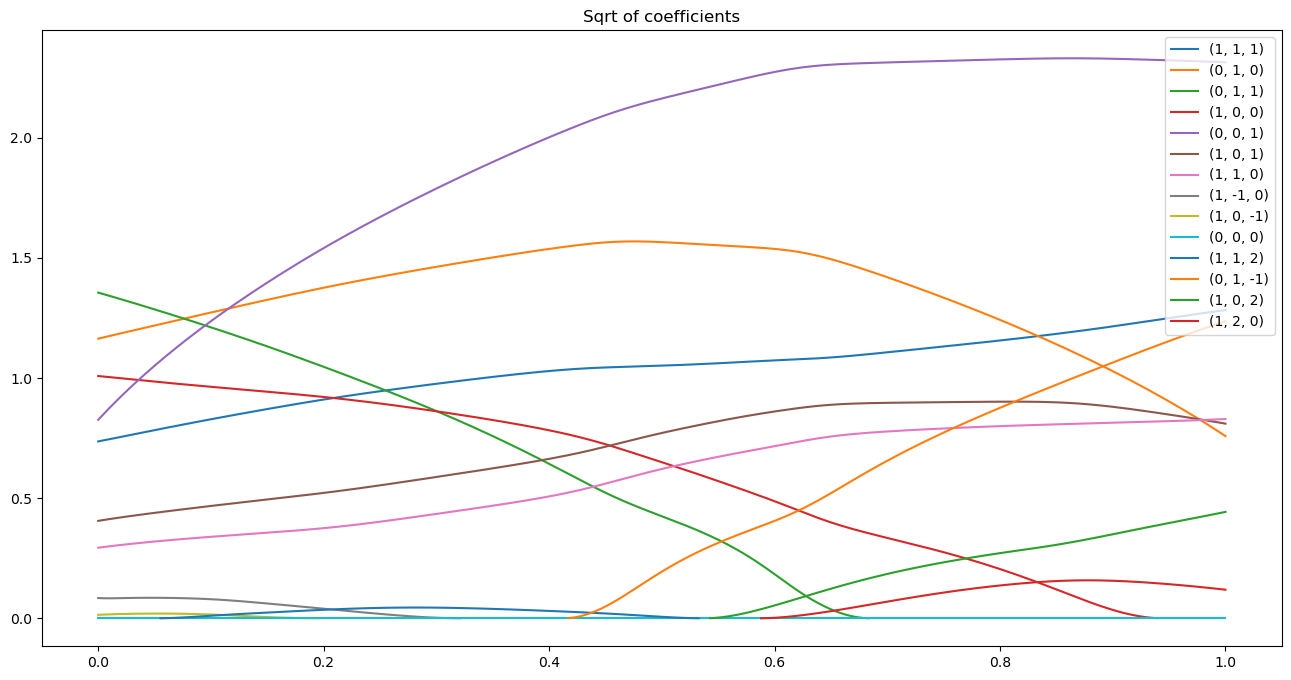

In [82]:
# Random matrices
np.random.seed(38)
relax = 0.5
D0,D1 = np.random.randn(2,3,3)
D0,D1 = [lp.dot_AA(D.T,D)+relax*np.eye(3) for D in (D0,D1)]

tmin,tmax = 0,1
T = np.linspace(tmin,tmax,200)
D = (1-T)*D0[:,:,None]+T*D1[:,:,None]
decomps = [smooth3_decomp(Di)[:2] for Di in np.moveaxis(D,-1,0)]
nmax = np.max([len(λ) for (λ,_) in decomps])
λ = np.zeros((nmax,len(decomps)))
e = np.zeros((3,nmax,len(decomps)),dtype=int)
for i,(λi,ei) in enumerate(decomps):
    ni = len(λi)
    λ[:ni,i]=λi
    e[:,:ni,i]=ei

rec = np.sum(λ*lp.outer_self(e),axis=2)
assert np.allclose(rec,D)

decomp = Selling.GatherByOffset(T,λ,e)
fig = plt.figure(figsize=(16,8)); plt.title(f"Sqrt of coefficients")
for offset,(time,coef) in decomp.items(): plt.plot(time,np.sqrt(coef))
#plt.ylim(0,0.3)
plt.legend(decomp.keys(),loc="upper right");

The decomposition uses more offsets than the usual Selling decomposition, as expected. A preliminary analysis suggests that a smooth decomposition exists that uses at most 13 offsets, which should achievable with the above method (possibly suitably tuned).

In [83]:
np.unique([len(w) for w,_ in decomps],return_counts=True)

(array([ 8,  9, 10]), array([ 31, 120,  49]))

In any case, at least 13 offsets are required in the neighborhood of the identity matrix.

In [84]:
λ,e = smooth3_decomp(np.eye(3))
print(f"Number of weights and offsets for the identity matrix decomposition : {len(λ)}")
λ,e

Number of weights and offsets for the identity matrix decomposition : 13


/var/folders/pr/ywmc0vdj1_q45y494__w0nsr0000gn/T/ipykernel_72775/2393254036.py:15: RuntimeWarning: invalid value encountered in log
  def objective(λ): λ = complement(λ); return np.sum(-λ/ϵ - μ*np.log(λ) + 0.5*λ**2/μ)


(array([0.00884536, 0.03453354, 0.03453354, 0.82648441, 0.82648441, 0.82648441, 0.00884536, 0.03453354, 0.03453354, 0.00884536, 0.03453354, 0.00884536, 0.03453354]),
 array([[-1, -1, -1,  0,  0, -1,  1,  1,  0, -1,  1, -1,  0],
        [-1,  0, -1,  0, -1,  0, -1, -1,  1,  1,  0, -1, -1],
        [-1, -1,  0, -1,  0,  0, -1,  0, -1, -1, -1,  1, -1]]))

### 6.2 Comparison with the C++ implementation

A slightly more usable C++ implementation, still slow and experimental, is provided. We check below that it matches the Python implementation. 

**Availability.** This final subsection assumes that the [FileVDQ](https://github.com/Mirebeau/HamiltonFastMarching/tree/master/Interfaces/FileVDQ) library is compiled, with the SmoothDecomp flag. No GPU support yet, although this should be trivial to add when needed.

In [85]:
from agd.Eikonal import VoronoiDecomposition

In [86]:
def normalize_decomp(λ,e,tol=1e-12):
    pos = λ>tol; λ = λ[pos]; e = e[:,pos] # eliminate zero weights
    ord = np.argsort(np.abs(sum(100**i*ei for i,ei in enumerate(e))))
    λ = λ[ord]; e = e[:,ord]
    return λ,e

In [87]:
np.random.seed(42)
ntest = 1000
relax = 0.5
D = np.random.randn(3,3,ntest)
D = lp.dot_AA(lp.transpose(D),D)+relax*np.eye(3)[:,:,None]
for i,Di in enumerate(np.moveaxis(D,-1,0)):
    λP,eP = normalize_decomp(*smooth3_decomp(Di)[:2])
    λC,eC = normalize_decomp(*VoronoiDecomposition(Di,smooth=True))
    if len(λC)!=len(λP): print(i,"Unequal stencil size")
    elif not np.allclose(λC,λP): print(i,np.max(np.abs(λC-λP)))

/var/folders/pr/ywmc0vdj1_q45y494__w0nsr0000gn/T/ipykernel_72775/2393254036.py:15: RuntimeWarning: invalid value encountered in log
  def objective(λ): λ = complement(λ); return np.sum(-λ/ϵ - μ*np.log(λ) + 0.5*λ**2/μ)


Sometimes a different stencil is obtained, but this is only due to roundoff error.

In [88]:
Di=D[:,:,157] # Assumes seed 42, ntest = 1000
λP,eP = normalize_decomp(*smooth3_decomp(Di)[:2],tol=0)
λC,eC = normalize_decomp(*VoronoiDecomposition(Di,smooth=True),tol=0)
λP,λC # Not the same length, due to almost zero coefficient in 5th position

(array([1.79966517e+00, 2.82945906e-01, 1.97789446e-01, 2.35956346e+00, 6.66807093e+00, 9.52499584e-02, 9.21649353e-01, 6.03618479e-02, 1.55966725e-02, 5.65366515e-03]),
 array([1.79966517e+00, 2.82945906e-01, 1.97789446e-01, 9.59518122e-19, 2.35956346e+00, 6.66807093e+00, 9.52499584e-02, 9.21649353e-01, 6.03618479e-02, 1.55966725e-02, 5.65366515e-03]))

The C implementation is obviously much faster than the Python one. 

In [89]:
%%time
VoronoiDecomposition(D,smooth=True);

CPU times: user 707 µs, sys: 3.27 ms, total: 3.98 ms
Wall time: 43.2 ms


(array([[3.52041362e+00, 3.35051667e+00, 4.51050651e-01, ..., 9.20535412e-01, 1.36756739e+00, 2.24773471e-01],
        [3.92909809e-01, 1.09185929e-01, 1.87170234e-01, ..., 4.45705538e+00, 6.19884062e-01, 2.46481247e-01],
        [1.57546841e+00, 5.72829228e-01, 3.04706575e-01, ..., 4.93940444e+00, 1.57386327e+00, 2.54528785e+00],
        ...,
        [1.75853242e-03, 0.00000000e+00, 0.00000000e+00, ..., 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ..., 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ..., 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]),
 array([[[ 1,  0, -1, ...,  1, -1,  0],
         [ 1,  0, -1, ...,  0,  0, -1],
         [ 1, -1,  0, ...,  0, -1,  0],
         ...,
         [ 2,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0]],
 
        [[ 0,  1,  1, ..., -1,  0, -2],
         [ 0,  1,  1, 

The two dimensional decomposition is also implemented in C. The speedup is also significant, although in that case the Python performance is less catastrophic.

In [90]:
np.random.seed(42)
ntest = 1000
relax = 0.5
D = np.random.randn(2,2,ntest)
D = lp.dot_AA(lp.transpose(D),D)+relax*np.eye(2)[:,:,None]
for i,Di in enumerate(np.moveaxis(D,-1,0)):
    λP,eP = normalize_decomp(*smooth_decomp(Di)[:2])
    λC,eC = normalize_decomp(*VoronoiDecomposition(Di,smooth=True))
    if len(λC)!=len(λP): print(i,"Unequal stencil size")
    elif not np.allclose(λC,λP): print(i,np.max(np.abs(λC-λP)))